# Import library and model

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, GRU

# Import, scale and split Dataset

In [2]:
# Import Dataset
 # EUR - VND
eur = pd.read_csv('Dataset\EUR_VND.csv')
 # GBP - VND
gbp = pd.read_csv("Dataset\GBP_VND.csv")
 # JPY - VND
jpy = pd.read_csv("Dataset\JPY_VND.csv")
# Convert
eur = eur['Sale'].replace({',':''}, regex=True).astype(float)
gbp = gbp['Sale'].replace({',':''}, regex=True).astype(float)
jpy = jpy['Sale'].replace({',':''}, regex=True).astype(float)

In [3]:
# Scale data
 # Scaler model
scaler=MinMaxScaler(feature_range=(0,1))
 # EUR - VND
eur_sc = scaler.fit_transform(np.array(eur).reshape(-1,1))
 # GBP - VND
gbp_sc = scaler.fit_transform(np.array(gbp).reshape(-1,1))
 # JPY - VND
jpy_sc = scaler.fit_transform(np.array(jpy).reshape(-1,1))

In [4]:
# Split train, test, validate data
#### EUR - VND
  # case 1. 7:3
train_eur_1_sc = eur_sc[:int(0.7*len(eur))]
test_eur_1_sc = eur_sc[int(0.7*len(eur)):]
  # case 2. 8:2
train_eur_2_sc = eur_sc[:int(0.8*len(eur))]
test_eur_2_sc = eur_sc[int(0.8*len(eur)):]
  # case 3. 9:1
train_eur_3_sc = eur_sc[:int(0.9*len(eur))]
test_eur_3_sc = eur_sc[int(0.9*len(eur)):]
#### GBP - VND
  # case 1. 7:3
train_gbp_1_sc = gbp_sc[:int(0.7*len(gbp))]
test_gbp_1_sc = gbp_sc[int(0.7*len(gbp)):]
  # case 2. 8:2
train_gbp_2_sc = gbp_sc[:int(0.8*len(gbp))]
test_gbp_2_sc = gbp_sc[int(0.8*len(gbp)):]
  # case 3. 9:1
train_gbp_3_sc = gbp_sc[:int(0.9*len(gbp))]
test_gbp_3_sc = gbp_sc[int(0.9*len(gbp)):]
#### JPY - VND
  # case 1. 7:3
train_jpy_1_sc = jpy_sc[:int(0.7*len(jpy))]
test_jpy_1_sc = jpy_sc[int(0.7*len(jpy)):]
  # case 2. 8:2
train_jpy_2_sc = jpy_sc[:int(0.8*len(jpy))]
test_jpy_2_sc = jpy_sc[int(0.8*len(jpy)):]
  # case 3. 9:1
train_jpy_3_sc = jpy_sc[:int(0.9*len(jpy))]
test_jpy_3_sc = jpy_sc[int(0.9*len(jpy)):]

# Standardizate function

In [5]:
# Function to standardizate the data
def standardizate_data(train, test, pre_test, f3, f6, f9):
    # Train
    train = np.reshape(train, (-1,1))
    train1 = scaler.inverse_transform(train)
    # Test
    test = np.reshape(test, (-1,1))
    test1 = scaler.inverse_transform(test)
    # Test prediction
    pre_test = np.reshape(pre_test, (-1,1))
    pre_test1 = scaler.inverse_transform(pre_test)
    # Forecast 30
    f3 = np.reshape(f3, (-1,1))
    f3_tf= scaler.inverse_transform(f3)
    # Forecast 60
    f6 = np.reshape(f6, (-1,1))
    f6_tf= scaler.inverse_transform(f6)
    # Forecast 90
    f9 = np.reshape(f9, (-1,1))
    f9_tf= scaler.inverse_transform(f9)
    
    return train1, test1, pre_test1, f3_tf, f6_tf, f9_tf 

# Convert-data Function

In [6]:
# Convert train, test data into X_train, y_train, X_test, t_test

# Function to convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

# Function to convert data
def convert_data(train, test, time_step):
    # Reshape into X = t, t+1, t+2 ,..., t+99 and Y = t+100
    X_train, y_train = create_dataset(train, time_step)
    X_test, y_test = create_dataset(test, time_step)
    # Reshape input to be [samples, time steps, features] which is required for LSTM
    X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)  # => 3D
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
    return X_train, y_train, X_test, y_test

# Forecast function

In [7]:
# Function to forecast next 30, 60, 90 days data
def forecast_days(model, test):
    x_input = test[len(test)-100:].reshape(1,-1)

    temp_input=list(x_input)
    temp_input=temp_input[0].tolist()

    forecast30 = []
    forecast60 = []
    forecast90 = []
    #lst_output=[]
    n_steps=100
    i=0
    while(i<=90):
        if(len(temp_input)>100):
            x_input=np.array(temp_input[1:])
            print("{} day input {}".format(i,x_input))
            x_input = x_input.reshape(1,-1)
            x_input = x_input.reshape((1, n_steps, 1)) #3D
            yhat = model.predict(x_input, verbose=0)
            print("{} day output {}".format(i,yhat))
            temp_input.extend(yhat[0].tolist())
            temp_input=temp_input[1:]
            if i <= 30:
                forecast30.extend(yhat.tolist())
            elif i <= 60:
                forecast60.extend(yhat.tolist())
            else:
                forecast90.extend(yhat.tolist())
            i=i+1
        else:
            x_input = x_input.reshape((1, n_steps, 1))
            yhat = model.predict(x_input, verbose=0)
            print(yhat[0])
            temp_input.extend(yhat[0].tolist())
            print(len(temp_input))
            forecast30.extend(yhat.tolist())
            i=i+1
    return forecast30, forecast60, forecast90

# Visualize function

In [8]:
# Function to visualize the model
def visualize_RNN(model, train, test, pre_test, f3, f6, f9):
    # set index
    train_index = pd.RangeIndex(start=0, stop=len(train), step=1)
    test_index = pd.RangeIndex(start=len(train), stop=len(train)+len(test), step=1) 
    pre_test_index = pd.RangeIndex(start=len(train)+101, stop=len(train)+len(test), step=1)
    f3_index = pd.RangeIndex(start=len(train)+len(test)-1, stop=len(train)+len(test)+30, step=1)
    f6_index = pd.RangeIndex(start=len(train)+len(test)+30, stop=len(train)+len(test)+60, step=1)
    f9_index = pd.RangeIndex(start=len(train)+len(test)+60, stop=len(train)+len(test)+90, step=1)
    
    # Visualize
    plt.figure(figsize=(12, 6))
    plt.plot(train_index, scaler.inverse_transform(train))
    plt.plot(test_index, scaler.inverse_transform(test))
    plt.plot(pre_test_index,scaler.inverse_transform(pre_test))
    plt.plot(f3_index, scaler.inverse_transform(f3))
    plt.plot(f6_index, scaler.inverse_transform(f6))
    plt.plot(f9_index, scaler.inverse_transform(f9))
    plt.title('RNN Time Series Forecast')
    plt.xlabel('Date')
    plt.ylabel('Exchange Rate (VND)')
    plt.legend(['Train','Test','TestPred','Forecast 30 days next','Forecast 60 days next','Forecast 90 days next'])
    plt.show()

# Evaluate function

In [9]:
# Function to evaluate the model
def evaluate(forecast, actual):
    forecast = np.array(forecast)
    actual = np.array(actual)
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))*100  # MAPE
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE

    print('RMSE =',rmse)
    print('MAPE =',mape)
    print('MAE =',mae)

# Function to implement SimpleRNN

In [10]:
def implement_RNN(train, test):
    time_step = 100
    # Convert Train, Test data
    X_train, y_train, X_test, y_test = convert_data(train, test, time_step)

    # Define SimpleRNN model
    model = Sequential()
    model.add(SimpleRNN(50, input_shape=(time_step, 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',optimizer='adam')

    # Fit model
    model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

    # Predict Test data
    pre_test = model.predict(X_test)

    # Forecast next 30, 60, 90 days data
    forecast30, forecast60, forecast90 = forecast_days(model, test)

    # Visualize model
    visualize_RNN(model, train, test, pre_test, forecast30, forecast60, forecast90)

    # Standardizate
    train, test, pre_test, forecast30, forecast60, forecast90 = standardizate_data(train, test, pre_test, forecast30, forecast60, forecast90)

    # Measure accurancy
    test1 = test[101:]
    print('- Test: ')
    evaluate(pre_test, test1)

# EUR - VND

- **Case 1. 7:3**

Epoch 1/100


C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.2555 - val_loss: 0.0093
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0119 - val_loss: 5.7703e-04
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0021 - val_loss: 5.6152e-04
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011 - val_loss: 5.9659e-04
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.2462e-04 - val_loss: 5.7151e-04
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.4167e-04 - val_loss: 5.5212e-04
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.0190e-04 - val_loss: 5.6276e-04
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.9013e-04 - val_loss: 5.4630e-04
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.9793e-04 - val_loss: 5.3773e-04
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.9065e-04 - val_loss: 5.4130e-04
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.3795e-04 - val_loss: 5.3028e-

Epoch 65/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.2406e-04 - val_loss: 4.4537e-04
Epoch 66/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.2392e-04 - val_loss: 4.8601e-04
Epoch 67/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.9467e-04 - val_loss: 4.0446e-04
Epoch 68/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.8023e-04 - val_loss: 3.9449e-04
Epoch 69/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.7757e-04 - val_loss: 4.0513e-04
Epoch 70/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6747e-04 - val_loss: 4.1477e-04
Epoch 71/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.7941e-04 - val_loss: 4.3156e-04
Epoch 72/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.8532e-04 - val_loss: 3.9054e-04
Epoch 73/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.4995e-04 - val_loss: 5.0947e-04
Epoch 74/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.1400e-04 - val_loss: 5.0804e-04
Epoch 75/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/st

5 day output [[0.6756293]]
6 day input [0.70161148 0.68142376 0.66920489 0.66920489 0.66920489 0.65078803
 0.64087126 0.62156897 0.61607933 0.60651673 0.60651673 0.60651673
 0.60208961 0.61572516 0.61962104 0.66495484 0.69045511 0.69045511
 0.69045511 0.69328847 0.70391358 0.70462192 0.69612183 0.70586152
 0.70586152 0.70586152 0.7156012  0.72321587 0.74340358 0.75934124
 0.72534089 0.72534089 0.72534089 0.72675757 0.73649726 0.70426775
 0.7108199  0.69488224 0.69488224 0.69488224 0.69116345 0.70019479
 0.71471578 0.7311847  0.74057021 0.74057021 0.74057021 0.72604923
 0.71383035 0.7012573  0.70798654 0.7072782  0.7072782  0.7072782
 0.71737206 0.71648663 0.72073667 0.72976802 0.70391358 0.70391358
 0.70391358 0.68691341 0.65344431 0.66477776 0.64582964 0.67115282
 0.67115282 0.67115282 0.62652736 0.61590225 0.63591287 0.6415796
 0.63998583 0.63998583 0.63998583 0.64140251 0.6367983  0.60917301
 0.62705862 0.66265274 0.66265274 0.66265274 0.66584027 0.6607048
 0.66973614 0.71524703 0.7

13 day output [[0.6349204]]
14 day input [0.61607933 0.60651673 0.60651673 0.60651673 0.60208961 0.61572516
 0.61962104 0.66495484 0.69045511 0.69045511 0.69045511 0.69328847
 0.70391358 0.70462192 0.69612183 0.70586152 0.70586152 0.70586152
 0.7156012  0.72321587 0.74340358 0.75934124 0.72534089 0.72534089
 0.72534089 0.72675757 0.73649726 0.70426775 0.7108199  0.69488224
 0.69488224 0.69488224 0.69116345 0.70019479 0.71471578 0.7311847
 0.74057021 0.74057021 0.74057021 0.72604923 0.71383035 0.7012573
 0.70798654 0.7072782  0.7072782  0.7072782  0.71737206 0.71648663
 0.72073667 0.72976802 0.70391358 0.70391358 0.70391358 0.68691341
 0.65344431 0.66477776 0.64582964 0.67115282 0.67115282 0.67115282
 0.62652736 0.61590225 0.63591287 0.6415796  0.63998583 0.63998583
 0.63998583 0.64140251 0.6367983  0.60917301 0.62705862 0.66265274
 0.66265274 0.66265274 0.66584027 0.6607048  0.66973614 0.71524703
 0.70940322 0.70940322 0.70940322 0.71985125 0.7168408  0.69559058
 0.71489286 0.69966354 

22 day output [[0.5843502]]
23 day input [0.69045511 0.69045511 0.69328847 0.70391358 0.70462192 0.69612183
 0.70586152 0.70586152 0.70586152 0.7156012  0.72321587 0.74340358
 0.75934124 0.72534089 0.72534089 0.72534089 0.72675757 0.73649726
 0.70426775 0.7108199  0.69488224 0.69488224 0.69488224 0.69116345
 0.70019479 0.71471578 0.7311847  0.74057021 0.74057021 0.74057021
 0.72604923 0.71383035 0.7012573  0.70798654 0.7072782  0.7072782
 0.7072782  0.71737206 0.71648663 0.72073667 0.72976802 0.70391358
 0.70391358 0.70391358 0.68691341 0.65344431 0.66477776 0.64582964
 0.67115282 0.67115282 0.67115282 0.62652736 0.61590225 0.63591287
 0.6415796  0.63998583 0.63998583 0.63998583 0.64140251 0.6367983
 0.60917301 0.62705862 0.66265274 0.66265274 0.66265274 0.66584027
 0.6607048  0.66973614 0.71524703 0.70940322 0.70940322 0.70940322
 0.71985125 0.7168408  0.69559058 0.71489286 0.69966354 0.70408207
 0.69205177 0.69060493 0.68456805 0.67963892 0.67562932 0.67009395
 0.6670531  0.66115254 

32 day output [[0.5181159]]
33 day input [0.72321587 0.74340358 0.75934124 0.72534089 0.72534089 0.72534089
 0.72675757 0.73649726 0.70426775 0.7108199  0.69488224 0.69488224
 0.69488224 0.69116345 0.70019479 0.71471578 0.7311847  0.74057021
 0.74057021 0.74057021 0.72604923 0.71383035 0.7012573  0.70798654
 0.7072782  0.7072782  0.7072782  0.71737206 0.71648663 0.72073667
 0.72976802 0.70391358 0.70391358 0.70391358 0.68691341 0.65344431
 0.66477776 0.64582964 0.67115282 0.67115282 0.67115282 0.62652736
 0.61590225 0.63591287 0.6415796  0.63998583 0.63998583 0.63998583
 0.64140251 0.6367983  0.60917301 0.62705862 0.66265274 0.66265274
 0.66265274 0.66584027 0.6607048  0.66973614 0.71524703 0.70940322
 0.70940322 0.70940322 0.71985125 0.7168408  0.69559058 0.71489286
 0.69966354 0.70408207 0.69205177 0.69060493 0.68456805 0.67963892
 0.67562932 0.67009395 0.6670531  0.66115254 0.65559858 0.65123564
 0.64517081 0.64009041 0.63492042 0.62966704 0.62462223 0.61911458
 0.61357015 0.6082910

41 day output [[0.4482071]]
42 day input [0.7108199  0.69488224 0.69488224 0.69488224 0.69116345 0.70019479
 0.71471578 0.7311847  0.74057021 0.74057021 0.74057021 0.72604923
 0.71383035 0.7012573  0.70798654 0.7072782  0.7072782  0.7072782
 0.71737206 0.71648663 0.72073667 0.72976802 0.70391358 0.70391358
 0.70391358 0.68691341 0.65344431 0.66477776 0.64582964 0.67115282
 0.67115282 0.67115282 0.62652736 0.61590225 0.63591287 0.6415796
 0.63998583 0.63998583 0.63998583 0.64140251 0.6367983  0.60917301
 0.62705862 0.66265274 0.66265274 0.66265274 0.66584027 0.6607048
 0.66973614 0.71524703 0.70940322 0.70940322 0.70940322 0.71985125
 0.7168408  0.69559058 0.71489286 0.69966354 0.70408207 0.69205177
 0.69060493 0.68456805 0.67963892 0.67562932 0.67009395 0.6670531
 0.66115254 0.65559858 0.65123564 0.64517081 0.64009041 0.63492042
 0.62966704 0.62462223 0.61911458 0.61357015 0.60829109 0.60236824
 0.59658778 0.59035659 0.58435023 0.57827181 0.57211387 0.56586242
 0.55942404 0.55276829 0.

51 day output [[0.35984516]]
52 day input [0.74057021 0.72604923 0.71383035 0.7012573  0.70798654 0.7072782
 0.7072782  0.7072782  0.71737206 0.71648663 0.72073667 0.72976802
 0.70391358 0.70391358 0.70391358 0.68691341 0.65344431 0.66477776
 0.64582964 0.67115282 0.67115282 0.67115282 0.62652736 0.61590225
 0.63591287 0.6415796  0.63998583 0.63998583 0.63998583 0.64140251
 0.6367983  0.60917301 0.62705862 0.66265274 0.66265274 0.66265274
 0.66584027 0.6607048  0.66973614 0.71524703 0.70940322 0.70940322
 0.70940322 0.71985125 0.7168408  0.69559058 0.71489286 0.69966354
 0.70408207 0.69205177 0.69060493 0.68456805 0.67963892 0.67562932
 0.67009395 0.6670531  0.66115254 0.65559858 0.65123564 0.64517081
 0.64009041 0.63492042 0.62966704 0.62462223 0.61911458 0.61357015
 0.60829109 0.60236824 0.59658778 0.59035659 0.58435023 0.57827181
 0.57211387 0.56586242 0.55942404 0.55276829 0.54615349 0.53929991
 0.53240579 0.52531743 0.51811588 0.51092839 0.50346088 0.49603644
 0.48833001 0.4805583

61 day output [[0.2665388]]
62 day input [0.72073667 0.72976802 0.70391358 0.70391358 0.70391358 0.68691341
 0.65344431 0.66477776 0.64582964 0.67115282 0.67115282 0.67115282
 0.62652736 0.61590225 0.63591287 0.6415796  0.63998583 0.63998583
 0.63998583 0.64140251 0.6367983  0.60917301 0.62705862 0.66265274
 0.66265274 0.66265274 0.66584027 0.6607048  0.66973614 0.71524703
 0.70940322 0.70940322 0.70940322 0.71985125 0.7168408  0.69559058
 0.71489286 0.69966354 0.70408207 0.69205177 0.69060493 0.68456805
 0.67963892 0.67562932 0.67009395 0.6670531  0.66115254 0.65559858
 0.65123564 0.64517081 0.64009041 0.63492042 0.62966704 0.62462223
 0.61911458 0.61357015 0.60829109 0.60236824 0.59658778 0.59035659
 0.58435023 0.57827181 0.57211387 0.56586242 0.55942404 0.55276829
 0.54615349 0.53929991 0.53240579 0.52531743 0.51811588 0.51092839
 0.50346088 0.49603644 0.48833001 0.48055831 0.47266704 0.46459728
 0.45648813 0.44820711 0.43981934 0.43135744 0.42271593 0.41403469
 0.40520874 0.3962979

71 day output [[0.18040474]]
72 day input [0.67115282 0.67115282 0.62652736 0.61590225 0.63591287 0.6415796
 0.63998583 0.63998583 0.63998583 0.64140251 0.6367983  0.60917301
 0.62705862 0.66265274 0.66265274 0.66265274 0.66584027 0.6607048
 0.66973614 0.71524703 0.70940322 0.70940322 0.70940322 0.71985125
 0.7168408  0.69559058 0.71489286 0.69966354 0.70408207 0.69205177
 0.69060493 0.68456805 0.67963892 0.67562932 0.67009395 0.6670531
 0.66115254 0.65559858 0.65123564 0.64517081 0.64009041 0.63492042
 0.62966704 0.62462223 0.61911458 0.61357015 0.60829109 0.60236824
 0.59658778 0.59035659 0.58435023 0.57827181 0.57211387 0.56586242
 0.55942404 0.55276829 0.54615349 0.53929991 0.53240579 0.52531743
 0.51811588 0.51092839 0.50346088 0.49603644 0.48833001 0.48055831
 0.47266704 0.46459728 0.45648813 0.44820711 0.43981934 0.43135744
 0.42271593 0.41403469 0.40520874 0.39629793 0.3873167  0.37820753
 0.3690778  0.35984516 0.35057741 0.34126931 0.33190089 0.32254142
 0.31315061 0.30377153 

81 day output [[0.11343697]]
82 day input [0.6367983  0.60917301 0.62705862 0.66265274 0.66265274 0.66265274
 0.66584027 0.6607048  0.66973614 0.71524703 0.70940322 0.70940322
 0.70940322 0.71985125 0.7168408  0.69559058 0.71489286 0.69966354
 0.70408207 0.69205177 0.69060493 0.68456805 0.67963892 0.67562932
 0.67009395 0.6670531  0.66115254 0.65559858 0.65123564 0.64517081
 0.64009041 0.63492042 0.62966704 0.62462223 0.61911458 0.61357015
 0.60829109 0.60236824 0.59658778 0.59035659 0.58435023 0.57827181
 0.57211387 0.56586242 0.55942404 0.55276829 0.54615349 0.53929991
 0.53240579 0.52531743 0.51811588 0.51092839 0.50346088 0.49603644
 0.48833001 0.48055831 0.47266704 0.46459728 0.45648813 0.44820711
 0.43981934 0.43135744 0.42271593 0.41403469 0.40520874 0.39629793
 0.3873167  0.37820753 0.3690778  0.35984516 0.35057741 0.34126931
 0.33190089 0.32254142 0.31315061 0.30377153 0.29441589 0.28506652
 0.27578321 0.2665388  0.25737303 0.24829736 0.23930879 0.23045073
 0.22171047 0.213116

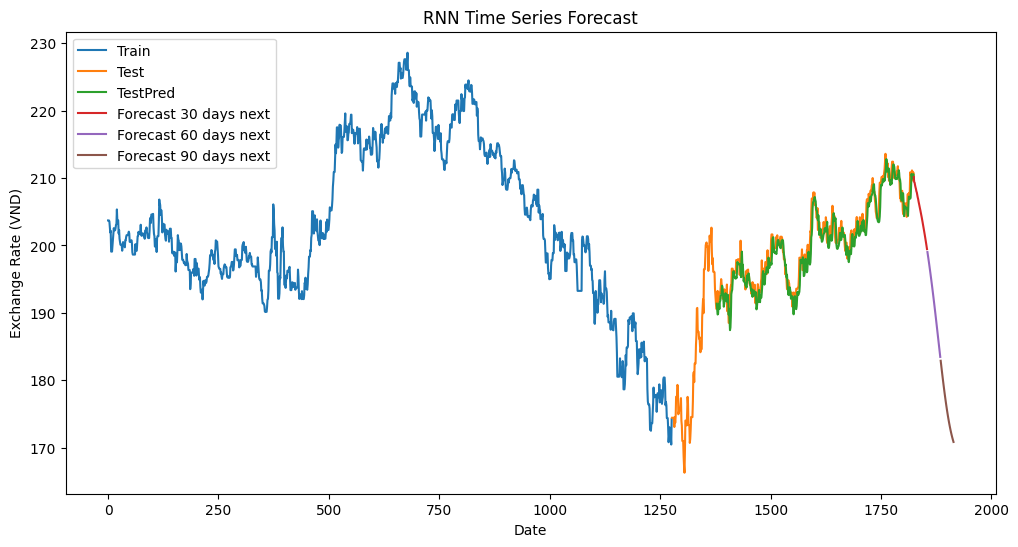

- Test: 
RMSE = 1.6753489514302993
MAPE = 0.646271117176426
MAE = 1.29739455512433


In [11]:
implement_RNN(train_eur_1_sc, test_eur_1_sc)

- **Case 2. 8:2**

Epoch 1/100


C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0406 - val_loss: 0.0047
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - val_loss: 7.6014e-04
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - val_loss: 6.9837e-04
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0012 - val_loss: 6.6312e-04
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011 - val_loss: 6.2640e-04
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0010 - val_loss: 5.9749e-04
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.2112e-04 - val_loss: 5.8376e-04
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.0543e-04 - val_loss: 5.4532e-04
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.4465e-04 - val_loss: 5.1836e-04
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.7213e-04 - val_loss: 5.8644e-04
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.3740e-04 - val_loss: 4.8130e-04
Epoch 12/10

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.1597e-04 - val_loss: 3.2601e-04
Epoch 66/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.2848e-04 - val_loss: 3.0660e-04
Epoch 67/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7848e-04 - val_loss: 2.9725e-04
Epoch 68/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.1655e-04 - val_loss: 3.2477e-04
Epoch 69/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.9070e-04 - val_loss: 3.2045e-04
Epoch 70/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.4992e-04 - val_loss: 3.1780e-04
Epoch 71/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.3796e-04 - val_loss: 3.0370e-04
Epoch 72/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.4152e-04 - val_loss: 2.9959e-04
Epoch 73/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.9282e-04 - val_loss: 2.9708e-04
Epoch 74/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.8090e-04 - val_loss: 2.9790e-04
Epoch 75/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.9853e-04 -

4 day output [[0.75186396]]
5 day input [0.68284045 0.70161148 0.68142376 0.66920489 0.66920489 0.66920489
 0.65078803 0.64087126 0.62156897 0.61607933 0.60651673 0.60651673
 0.60651673 0.60208961 0.61572516 0.61962104 0.66495484 0.69045511
 0.69045511 0.69045511 0.69328847 0.70391358 0.70462192 0.69612183
 0.70586152 0.70586152 0.70586152 0.7156012  0.72321587 0.74340358
 0.75934124 0.72534089 0.72534089 0.72534089 0.72675757 0.73649726
 0.70426775 0.7108199  0.69488224 0.69488224 0.69488224 0.69116345
 0.70019479 0.71471578 0.7311847  0.74057021 0.74057021 0.74057021
 0.72604923 0.71383035 0.7012573  0.70798654 0.7072782  0.7072782
 0.7072782  0.71737206 0.71648663 0.72073667 0.72976802 0.70391358
 0.70391358 0.70391358 0.68691341 0.65344431 0.66477776 0.64582964
 0.67115282 0.67115282 0.67115282 0.62652736 0.61590225 0.63591287
 0.6415796  0.63998583 0.63998583 0.63998583 0.64140251 0.6367983
 0.60917301 0.62705862 0.66265274 0.66265274 0.66265274 0.66584027
 0.6607048  0.66973614 0

14 day output [[0.8434238]]
15 day input [0.60651673 0.60651673 0.60651673 0.60208961 0.61572516 0.61962104
 0.66495484 0.69045511 0.69045511 0.69045511 0.69328847 0.70391358
 0.70462192 0.69612183 0.70586152 0.70586152 0.70586152 0.7156012
 0.72321587 0.74340358 0.75934124 0.72534089 0.72534089 0.72534089
 0.72675757 0.73649726 0.70426775 0.7108199  0.69488224 0.69488224
 0.69488224 0.69116345 0.70019479 0.71471578 0.7311847  0.74057021
 0.74057021 0.74057021 0.72604923 0.71383035 0.7012573  0.70798654
 0.7072782  0.7072782  0.7072782  0.71737206 0.71648663 0.72073667
 0.72976802 0.70391358 0.70391358 0.70391358 0.68691341 0.65344431
 0.66477776 0.64582964 0.67115282 0.67115282 0.67115282 0.62652736
 0.61590225 0.63591287 0.6415796  0.63998583 0.63998583 0.63998583
 0.64140251 0.6367983  0.60917301 0.62705862 0.66265274 0.66265274
 0.66265274 0.66584027 0.6607048  0.66973614 0.71524703 0.70940322
 0.70940322 0.70940322 0.71985125 0.7168408  0.69559058 0.71489286
 0.69966354 0.71329993

24 day output [[0.9360348]]
25 day input [0.69328847 0.70391358 0.70462192 0.69612183 0.70586152 0.70586152
 0.70586152 0.7156012  0.72321587 0.74340358 0.75934124 0.72534089
 0.72534089 0.72534089 0.72675757 0.73649726 0.70426775 0.7108199
 0.69488224 0.69488224 0.69488224 0.69116345 0.70019479 0.71471578
 0.7311847  0.74057021 0.74057021 0.74057021 0.72604923 0.71383035
 0.7012573  0.70798654 0.7072782  0.7072782  0.7072782  0.71737206
 0.71648663 0.72073667 0.72976802 0.70391358 0.70391358 0.70391358
 0.68691341 0.65344431 0.66477776 0.64582964 0.67115282 0.67115282
 0.67115282 0.62652736 0.61590225 0.63591287 0.6415796  0.63998583
 0.63998583 0.63998583 0.64140251 0.6367983  0.60917301 0.62705862
 0.66265274 0.66265274 0.66265274 0.66584027 0.6607048  0.66973614
 0.71524703 0.70940322 0.70940322 0.70940322 0.71985125 0.7168408
 0.69559058 0.71489286 0.69966354 0.71329993 0.72141755 0.73039907
 0.74089533 0.75186396 0.76445085 0.77283025 0.78219956 0.79063499
 0.79748952 0.8058967  

34 day output [[1.0172036]]
35 day input [0.75934124 0.72534089 0.72534089 0.72534089 0.72675757 0.73649726
 0.70426775 0.7108199  0.69488224 0.69488224 0.69488224 0.69116345
 0.70019479 0.71471578 0.7311847  0.74057021 0.74057021 0.74057021
 0.72604923 0.71383035 0.7012573  0.70798654 0.7072782  0.7072782
 0.7072782  0.71737206 0.71648663 0.72073667 0.72976802 0.70391358
 0.70391358 0.70391358 0.68691341 0.65344431 0.66477776 0.64582964
 0.67115282 0.67115282 0.67115282 0.62652736 0.61590225 0.63591287
 0.6415796  0.63998583 0.63998583 0.63998583 0.64140251 0.6367983
 0.60917301 0.62705862 0.66265274 0.66265274 0.66265274 0.66584027
 0.6607048  0.66973614 0.71524703 0.70940322 0.70940322 0.70940322
 0.71985125 0.7168408  0.69559058 0.71489286 0.69966354 0.71329993
 0.72141755 0.73039907 0.74089533 0.75186396 0.76445085 0.77283025
 0.78219956 0.79063499 0.79748952 0.8058967  0.8184914  0.82571709
 0.83322078 0.84342378 0.85170662 0.85995537 0.87133044 0.88073581
 0.88681239 0.89782494 

42 day output [[1.0716875]]
43 day input [0.69488224 0.69488224 0.69488224 0.69116345 0.70019479 0.71471578
 0.7311847  0.74057021 0.74057021 0.74057021 0.72604923 0.71383035
 0.7012573  0.70798654 0.7072782  0.7072782  0.7072782  0.71737206
 0.71648663 0.72073667 0.72976802 0.70391358 0.70391358 0.70391358
 0.68691341 0.65344431 0.66477776 0.64582964 0.67115282 0.67115282
 0.67115282 0.62652736 0.61590225 0.63591287 0.6415796  0.63998583
 0.63998583 0.63998583 0.64140251 0.6367983  0.60917301 0.62705862
 0.66265274 0.66265274 0.66265274 0.66584027 0.6607048  0.66973614
 0.71524703 0.70940322 0.70940322 0.70940322 0.71985125 0.7168408
 0.69559058 0.71489286 0.69966354 0.71329993 0.72141755 0.73039907
 0.74089533 0.75186396 0.76445085 0.77283025 0.78219956 0.79063499
 0.79748952 0.8058967  0.8184914  0.82571709 0.83322078 0.84342378
 0.85170662 0.85995537 0.87133044 0.88073581 0.88681239 0.89782494
 0.90697497 0.91720891 0.92591786 0.9360348  0.94373411 0.95258945
 0.96191227 0.96976537

52 day output [[1.1232815]]
53 day input [0.72604923 0.71383035 0.7012573  0.70798654 0.7072782  0.7072782
 0.7072782  0.71737206 0.71648663 0.72073667 0.72976802 0.70391358
 0.70391358 0.70391358 0.68691341 0.65344431 0.66477776 0.64582964
 0.67115282 0.67115282 0.67115282 0.62652736 0.61590225 0.63591287
 0.6415796  0.63998583 0.63998583 0.63998583 0.64140251 0.6367983
 0.60917301 0.62705862 0.66265274 0.66265274 0.66265274 0.66584027
 0.6607048  0.66973614 0.71524703 0.70940322 0.70940322 0.70940322
 0.71985125 0.7168408  0.69559058 0.71489286 0.69966354 0.71329993
 0.72141755 0.73039907 0.74089533 0.75186396 0.76445085 0.77283025
 0.78219956 0.79063499 0.79748952 0.8058967  0.8184914  0.82571709
 0.83322078 0.84342378 0.85170662 0.85995537 0.87133044 0.88073581
 0.88681239 0.89782494 0.90697497 0.91720891 0.92591786 0.9360348
 0.94373411 0.95258945 0.96191227 0.96976537 0.97756481 0.98566753
 0.99460256 1.00240397 1.00998163 1.01720357 1.02440012 1.03185296
 1.03899229 1.04565203 1

61 day output [[1.1552464]]
62 day input [0.72073667 0.72976802 0.70391358 0.70391358 0.70391358 0.68691341
 0.65344431 0.66477776 0.64582964 0.67115282 0.67115282 0.67115282
 0.62652736 0.61590225 0.63591287 0.6415796  0.63998583 0.63998583
 0.63998583 0.64140251 0.6367983  0.60917301 0.62705862 0.66265274
 0.66265274 0.66265274 0.66584027 0.6607048  0.66973614 0.71524703
 0.70940322 0.70940322 0.70940322 0.71985125 0.7168408  0.69559058
 0.71489286 0.69966354 0.71329993 0.72141755 0.73039907 0.74089533
 0.75186396 0.76445085 0.77283025 0.78219956 0.79063499 0.79748952
 0.8058967  0.8184914  0.82571709 0.83322078 0.84342378 0.85170662
 0.85995537 0.87133044 0.88073581 0.88681239 0.89782494 0.90697497
 0.91720891 0.92591786 0.9360348  0.94373411 0.95258945 0.96191227
 0.96976537 0.97756481 0.98566753 0.99460256 1.00240397 1.00998163
 1.01720357 1.02440012 1.03185296 1.03899229 1.04565203 1.05212975
 1.05890644 1.06524873 1.07168746 1.0775882  1.08373368 1.08947265
 1.09499967 1.1000932

71 day output [[1.1777668]]
72 day input [0.67115282 0.67115282 0.62652736 0.61590225 0.63591287 0.6415796
 0.63998583 0.63998583 0.63998583 0.64140251 0.6367983  0.60917301
 0.62705862 0.66265274 0.66265274 0.66265274 0.66584027 0.6607048
 0.66973614 0.71524703 0.70940322 0.70940322 0.70940322 0.71985125
 0.7168408  0.69559058 0.71489286 0.69966354 0.71329993 0.72141755
 0.73039907 0.74089533 0.75186396 0.76445085 0.77283025 0.78219956
 0.79063499 0.79748952 0.8058967  0.8184914  0.82571709 0.83322078
 0.84342378 0.85170662 0.85995537 0.87133044 0.88073581 0.88681239
 0.89782494 0.90697497 0.91720891 0.92591786 0.9360348  0.94373411
 0.95258945 0.96191227 0.96976537 0.97756481 0.98566753 0.99460256
 1.00240397 1.00998163 1.01720357 1.02440012 1.03185296 1.03899229
 1.04565203 1.05212975 1.05890644 1.06524873 1.07168746 1.0775882
 1.08373368 1.08947265 1.09499967 1.10009325 1.10503209 1.11003578
 1.11467791 1.11911893 1.12328148 1.12753308 1.13139307 1.13534081
 1.13895047 1.14256299 1

81 day output [[1.1910582]]
82 day input [0.6367983  0.60917301 0.62705862 0.66265274 0.66265274 0.66265274
 0.66584027 0.6607048  0.66973614 0.71524703 0.70940322 0.70940322
 0.70940322 0.71985125 0.7168408  0.69559058 0.71489286 0.69966354
 0.71329993 0.72141755 0.73039907 0.74089533 0.75186396 0.76445085
 0.77283025 0.78219956 0.79063499 0.79748952 0.8058967  0.8184914
 0.82571709 0.83322078 0.84342378 0.85170662 0.85995537 0.87133044
 0.88073581 0.88681239 0.89782494 0.90697497 0.91720891 0.92591786
 0.9360348  0.94373411 0.95258945 0.96191227 0.96976537 0.97756481
 0.98566753 0.99460256 1.00240397 1.00998163 1.01720357 1.02440012
 1.03185296 1.03899229 1.04565203 1.05212975 1.05890644 1.06524873
 1.07168746 1.0775882  1.08373368 1.08947265 1.09499967 1.10009325
 1.10503209 1.11003578 1.11467791 1.11911893 1.12328148 1.12753308
 1.13139307 1.13534081 1.13895047 1.14256299 1.14598942 1.14929819
 1.15234911 1.15524638 1.15809512 1.16077876 1.16333282 1.16569376
 1.16800714 1.17015982

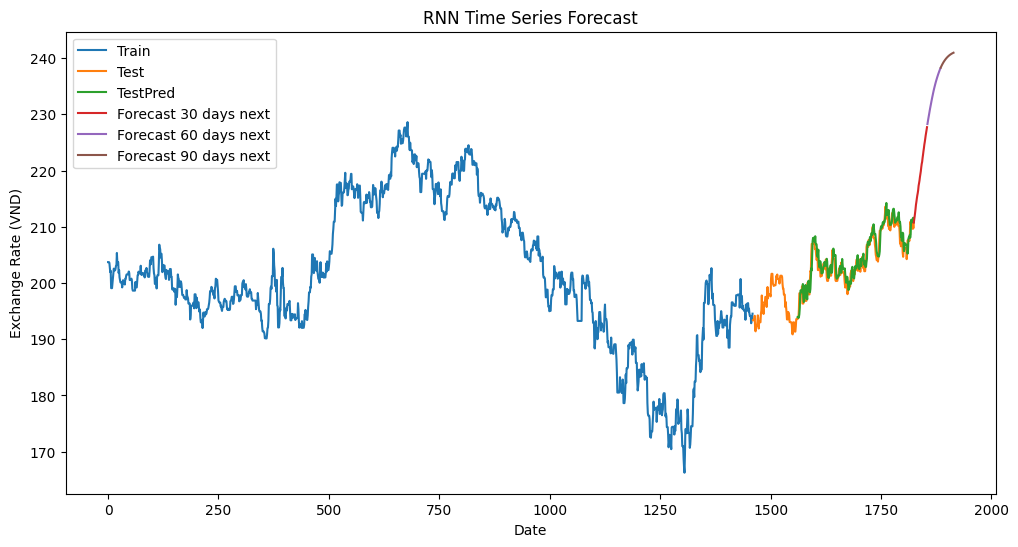

- Test: 
RMSE = 1.5467585157730332
MAPE = 0.5898938893283275
MAE = 1.2038634183315677


In [12]:
implement_RNN(train_eur_2_sc, test_eur_2_sc)

- **Case 3. 9:1**

Epoch 1/100


C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.4884 - val_loss: 0.0104
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0074 - val_loss: 9.2108e-04
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029 - val_loss: 8.6033e-04
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - val_loss: 8.5074e-04
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - val_loss: 8.4702e-04
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017 - val_loss: 8.2410e-04
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - val_loss: 8.2386e-04
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013 - val_loss: 9.4851e-04
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011 - val_loss: 9.1156e-04
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0012 - val_loss: 9.0579e-04
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━

Epoch 66/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.0642e-04 - val_loss: 4.0231e-04
Epoch 67/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.1683e-04 - val_loss: 3.9703e-04
Epoch 68/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.3157e-04 - val_loss: 3.9133e-04
Epoch 69/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.9473e-04 - val_loss: 3.8354e-04
Epoch 70/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.1305e-04 - val_loss: 4.3711e-04
Epoch 71/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.6870e-04 - val_loss: 4.1803e-04
Epoch 72/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.6278e-04 - val_loss: 5.0825e-04
Epoch 73/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.5322e-04 - val_loss: 4.1545e-04
Epoch 74/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.0561e-04 - val_loss: 4.4727e-04
Epoch 75/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.2979e-04 - val_loss: 4.2339e-04
Epoch 76/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 

4 day output [[0.7449322]]
5 day input [0.68284045 0.70161148 0.68142376 0.66920489 0.66920489 0.66920489
 0.65078803 0.64087126 0.62156897 0.61607933 0.60651673 0.60651673
 0.60651673 0.60208961 0.61572516 0.61962104 0.66495484 0.69045511
 0.69045511 0.69045511 0.69328847 0.70391358 0.70462192 0.69612183
 0.70586152 0.70586152 0.70586152 0.7156012  0.72321587 0.74340358
 0.75934124 0.72534089 0.72534089 0.72534089 0.72675757 0.73649726
 0.70426775 0.7108199  0.69488224 0.69488224 0.69488224 0.69116345
 0.70019479 0.71471578 0.7311847  0.74057021 0.74057021 0.74057021
 0.72604923 0.71383035 0.7012573  0.70798654 0.7072782  0.7072782
 0.7072782  0.71737206 0.71648663 0.72073667 0.72976802 0.70391358
 0.70391358 0.70391358 0.68691341 0.65344431 0.66477776 0.64582964
 0.67115282 0.67115282 0.67115282 0.62652736 0.61590225 0.63591287
 0.6415796  0.63998583 0.63998583 0.63998583 0.64140251 0.6367983
 0.60917301 0.62705862 0.66265274 0.66265274 0.66265274 0.66584027
 0.6607048  0.66973614 0.

12 day output [[0.7926375]]
13 day input [0.62156897 0.61607933 0.60651673 0.60651673 0.60651673 0.60208961
 0.61572516 0.61962104 0.66495484 0.69045511 0.69045511 0.69045511
 0.69328847 0.70391358 0.70462192 0.69612183 0.70586152 0.70586152
 0.70586152 0.7156012  0.72321587 0.74340358 0.75934124 0.72534089
 0.72534089 0.72534089 0.72675757 0.73649726 0.70426775 0.7108199
 0.69488224 0.69488224 0.69488224 0.69116345 0.70019479 0.71471578
 0.7311847  0.74057021 0.74057021 0.74057021 0.72604923 0.71383035
 0.7012573  0.70798654 0.7072782  0.7072782  0.7072782  0.71737206
 0.71648663 0.72073667 0.72976802 0.70391358 0.70391358 0.70391358
 0.68691341 0.65344431 0.66477776 0.64582964 0.67115282 0.67115282
 0.67115282 0.62652736 0.61590225 0.63591287 0.6415796  0.63998583
 0.63998583 0.63998583 0.64140251 0.6367983  0.60917301 0.62705862
 0.66265274 0.66265274 0.66265274 0.66584027 0.6607048  0.66973614
 0.71524703 0.70940322 0.70940322 0.70940322 0.71985125 0.7168408
 0.69559058 0.71489286 

20 day output [[0.83945584]]
21 day input [0.66495484 0.69045511 0.69045511 0.69045511 0.69328847 0.70391358
 0.70462192 0.69612183 0.70586152 0.70586152 0.70586152 0.7156012
 0.72321587 0.74340358 0.75934124 0.72534089 0.72534089 0.72534089
 0.72675757 0.73649726 0.70426775 0.7108199  0.69488224 0.69488224
 0.69488224 0.69116345 0.70019479 0.71471578 0.7311847  0.74057021
 0.74057021 0.74057021 0.72604923 0.71383035 0.7012573  0.70798654
 0.7072782  0.7072782  0.7072782  0.71737206 0.71648663 0.72073667
 0.72976802 0.70391358 0.70391358 0.70391358 0.68691341 0.65344431
 0.66477776 0.64582964 0.67115282 0.67115282 0.67115282 0.62652736
 0.61590225 0.63591287 0.6415796  0.63998583 0.63998583 0.63998583
 0.64140251 0.6367983  0.60917301 0.62705862 0.66265274 0.66265274
 0.66265274 0.66584027 0.6607048  0.66973614 0.71524703 0.70940322
 0.70940322 0.70940322 0.71985125 0.7168408  0.69559058 0.71489286
 0.69966354 0.71955222 0.7169199  0.73227364 0.73259497 0.74493217
 0.7438857  0.7497615

30 day output [[0.8954909]]
31 day input [0.70586152 0.7156012  0.72321587 0.74340358 0.75934124 0.72534089
 0.72534089 0.72534089 0.72675757 0.73649726 0.70426775 0.7108199
 0.69488224 0.69488224 0.69488224 0.69116345 0.70019479 0.71471578
 0.7311847  0.74057021 0.74057021 0.74057021 0.72604923 0.71383035
 0.7012573  0.70798654 0.7072782  0.7072782  0.7072782  0.71737206
 0.71648663 0.72073667 0.72976802 0.70391358 0.70391358 0.70391358
 0.68691341 0.65344431 0.66477776 0.64582964 0.67115282 0.67115282
 0.67115282 0.62652736 0.61590225 0.63591287 0.6415796  0.63998583
 0.63998583 0.63998583 0.64140251 0.6367983  0.60917301 0.62705862
 0.66265274 0.66265274 0.66265274 0.66584027 0.6607048  0.66973614
 0.71524703 0.70940322 0.70940322 0.70940322 0.71985125 0.7168408
 0.69559058 0.71489286 0.69966354 0.71955222 0.7169199  0.73227364
 0.73259497 0.74493217 0.7438857  0.74976152 0.75565928 0.76980531
 0.7737391  0.78261852 0.78708053 0.79263753 0.79411125 0.80648315
 0.80754137 0.81778586 

40 day output [[0.942986]]
41 day input [0.70426775 0.7108199  0.69488224 0.69488224 0.69488224 0.69116345
 0.70019479 0.71471578 0.7311847  0.74057021 0.74057021 0.74057021
 0.72604923 0.71383035 0.7012573  0.70798654 0.7072782  0.7072782
 0.7072782  0.71737206 0.71648663 0.72073667 0.72976802 0.70391358
 0.70391358 0.70391358 0.68691341 0.65344431 0.66477776 0.64582964
 0.67115282 0.67115282 0.67115282 0.62652736 0.61590225 0.63591287
 0.6415796  0.63998583 0.63998583 0.63998583 0.64140251 0.6367983
 0.60917301 0.62705862 0.66265274 0.66265274 0.66265274 0.66584027
 0.6607048  0.66973614 0.71524703 0.70940322 0.70940322 0.70940322
 0.71985125 0.7168408  0.69559058 0.71489286 0.69966354 0.71955222
 0.7169199  0.73227364 0.73259497 0.74493217 0.7438857  0.74976152
 0.75565928 0.76980531 0.7737391  0.78261852 0.78708053 0.79263753
 0.79411125 0.80648315 0.80754137 0.81778586 0.82189816 0.83135575
 0.83040804 0.83945584 0.84041965 0.84933501 0.85372543 0.864811
 0.86657661 0.87487614 0.8

50 day output [[0.9801798]]
51 day input [0.74057021 0.74057021 0.72604923 0.71383035 0.7012573  0.70798654
 0.7072782  0.7072782  0.7072782  0.71737206 0.71648663 0.72073667
 0.72976802 0.70391358 0.70391358 0.70391358 0.68691341 0.65344431
 0.66477776 0.64582964 0.67115282 0.67115282 0.67115282 0.62652736
 0.61590225 0.63591287 0.6415796  0.63998583 0.63998583 0.63998583
 0.64140251 0.6367983  0.60917301 0.62705862 0.66265274 0.66265274
 0.66265274 0.66584027 0.6607048  0.66973614 0.71524703 0.70940322
 0.70940322 0.70940322 0.71985125 0.7168408  0.69559058 0.71489286
 0.69966354 0.71955222 0.7169199  0.73227364 0.73259497 0.74493217
 0.7438857  0.74976152 0.75565928 0.76980531 0.7737391  0.78261852
 0.78708053 0.79263753 0.79411125 0.80648315 0.80754137 0.81778586
 0.82189816 0.83135575 0.83040804 0.83945584 0.84041965 0.84933501
 0.85372543 0.864811   0.86657661 0.87487614 0.87671828 0.88375497
 0.88500142 0.89549088 0.89716548 0.90614492 0.9074955  0.9156816
 0.91497511 0.92329043

60 day output [[1.010533]]
61 day input [0.71648663 0.72073667 0.72976802 0.70391358 0.70391358 0.70391358
 0.68691341 0.65344431 0.66477776 0.64582964 0.67115282 0.67115282
 0.67115282 0.62652736 0.61590225 0.63591287 0.6415796  0.63998583
 0.63998583 0.63998583 0.64140251 0.6367983  0.60917301 0.62705862
 0.66265274 0.66265274 0.66265274 0.66584027 0.6607048  0.66973614
 0.71524703 0.70940322 0.70940322 0.70940322 0.71985125 0.7168408
 0.69559058 0.71489286 0.69966354 0.71955222 0.7169199  0.73227364
 0.73259497 0.74493217 0.7438857  0.74976152 0.75565928 0.76980531
 0.7737391  0.78261852 0.78708053 0.79263753 0.79411125 0.80648315
 0.80754137 0.81778586 0.82189816 0.83135575 0.83040804 0.83945584
 0.84041965 0.84933501 0.85372543 0.864811   0.86657661 0.87487614
 0.87671828 0.88375497 0.88500142 0.89549088 0.89716548 0.90614492
 0.9074955  0.9156816  0.91497511 0.92329043 0.92452627 0.9329502
 0.93500495 0.94298601 0.94375372 0.94988716 0.95113057 0.95734215
 0.95922369 0.96616507 0

70 day output [[1.0339247]]
71 day input [0.67115282 0.67115282 0.67115282 0.62652736 0.61590225 0.63591287
 0.6415796  0.63998583 0.63998583 0.63998583 0.64140251 0.6367983
 0.60917301 0.62705862 0.66265274 0.66265274 0.66265274 0.66584027
 0.6607048  0.66973614 0.71524703 0.70940322 0.70940322 0.70940322
 0.71985125 0.7168408  0.69559058 0.71489286 0.69966354 0.71955222
 0.7169199  0.73227364 0.73259497 0.74493217 0.7438857  0.74976152
 0.75565928 0.76980531 0.7737391  0.78261852 0.78708053 0.79263753
 0.79411125 0.80648315 0.80754137 0.81778586 0.82189816 0.83135575
 0.83040804 0.83945584 0.84041965 0.84933501 0.85372543 0.864811
 0.86657661 0.87487614 0.87671828 0.88375497 0.88500142 0.89549088
 0.89716548 0.90614492 0.9074955  0.9156816  0.91497511 0.92329043
 0.92452627 0.9329502  0.93500495 0.94298601 0.94375372 0.94988716
 0.95113057 0.95734215 0.95922369 0.96616507 0.96817231 0.97382146
 0.97497094 0.98017979 0.98098832 0.98658353 0.98830688 0.99383068
 0.99501705 0.99992681 1

80 day output [[1.0501827]]
81 day input [0.64140251 0.6367983  0.60917301 0.62705862 0.66265274 0.66265274
 0.66265274 0.66584027 0.6607048  0.66973614 0.71524703 0.70940322
 0.70940322 0.70940322 0.71985125 0.7168408  0.69559058 0.71489286
 0.69966354 0.71955222 0.7169199  0.73227364 0.73259497 0.74493217
 0.7438857  0.74976152 0.75565928 0.76980531 0.7737391  0.78261852
 0.78708053 0.79263753 0.79411125 0.80648315 0.80754137 0.81778586
 0.82189816 0.83135575 0.83040804 0.83945584 0.84041965 0.84933501
 0.85372543 0.864811   0.86657661 0.87487614 0.87671828 0.88375497
 0.88500142 0.89549088 0.89716548 0.90614492 0.9074955  0.9156816
 0.91497511 0.92329043 0.92452627 0.9329502  0.93500495 0.94298601
 0.94375372 0.94988716 0.95113057 0.95734215 0.95922369 0.96616507
 0.96817231 0.97382146 0.97497094 0.98017979 0.98098832 0.98658353
 0.98830688 0.99383068 0.99501705 0.99992681 1.00045955 1.00479436
 1.00578499 1.01053298 1.01170516 1.01629925 1.0170964  1.02079749
 1.02121925 1.02493584

90 day output [[1.0622518]]


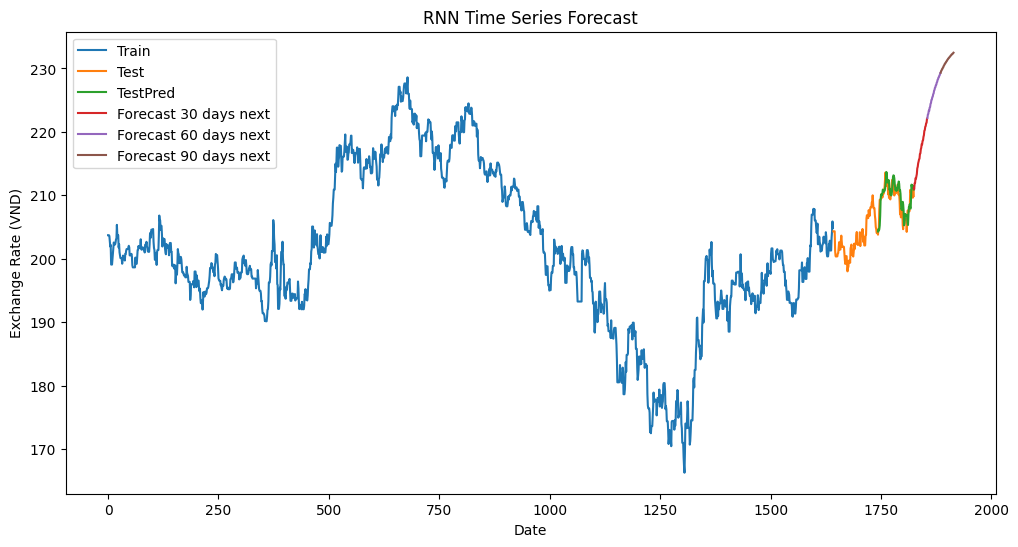

- Test: 
RMSE = 1.5858695035173065
MAPE = 0.5890444540981022
MAE = 1.2308844179939984


In [13]:
implement_RNN(train_eur_3_sc, test_eur_3_sc)

# GBP - VND

- **Case 1. 7:3**

Epoch 1/100


C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1691 - val_loss: 0.0033
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0089 - val_loss: 0.0020
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - val_loss: 0.0011
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013 - val_loss: 5.5630e-04
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.6096e-04 - val_loss: 5.4209e-04
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.5933e-04 - val_loss: 5.5211e-04
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.4052e-04 - val_loss: 6.9771e-04
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.4540e-04 - val_loss: 4.9654e-04
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.6375e-04 - val_loss: 4.8308e-04
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.7620e-04 - val_loss: 4.8879e-04
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.8845e-04 - val_loss: 4.6127e-04
Epoch 12/100


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.6367e-04 - val_loss: 3.4719e-04
Epoch 66/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.1999e-04 - val_loss: 3.6777e-04
Epoch 67/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.4059e-04 - val_loss: 3.5538e-04
Epoch 68/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.4581e-04 - val_loss: 3.7709e-04
Epoch 69/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.1989e-04 - val_loss: 3.6477e-04
Epoch 70/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.5099e-04 - val_loss: 6.7806e-04
Epoch 71/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.2812e-04 - val_loss: 3.5439e-04
Epoch 72/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.3526e-04 - val_loss: 3.4243e-04
Epoch 73/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.8582e-04 - val_loss: 3.3887e-04
Epoch 74/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.6917e-04 - val_loss: 4.6018e-04
Epoch 75/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.3

4 day output [[0.8029496]]
5 day input [0.73450723 0.75580126 0.75279825 0.75648376 0.75648376 0.75648376
 0.74979525 0.74105924 0.73027573 0.72167622 0.71048321 0.71048321
 0.71048321 0.71116571 0.71280371 0.70611521 0.74542725 0.78132678
 0.78132678 0.78132678 0.77354627 0.77764128 0.76180726 0.74938575
 0.75593776 0.75593776 0.75593776 0.75880426 0.76822277 0.78200928
 0.79183729 0.76535627 0.76535627 0.76535627 0.76931477 0.78924379
 0.75812176 0.78241878 0.76781327 0.76781327 0.76781327 0.76713077
 0.78692329 0.7959323  0.81094731 0.82350532 0.82350532 0.82350532
 0.80644281 0.79429429 0.78910729 0.8043953  0.8034398  0.8034398
 0.8034398  0.80985531 0.82295932 0.82555283 0.83114933 0.82241332
 0.82241332 0.82241332 0.80835381 0.77231777 0.78269178 0.76835927
 0.78883429 0.78883429 0.78883429 0.75279825 0.72836473 0.76194376
 0.76412776 0.76030576 0.76030576 0.76030576 0.76385476 0.76904177
 0.73983074 0.74406224 0.76999727 0.76999727 0.76999727 0.78228228
 0.76972427 0.77559378 0

14 day output [[0.8039439]]
15 day input [0.71048321 0.71048321 0.71048321 0.71116571 0.71280371 0.70611521
 0.74542725 0.78132678 0.78132678 0.78132678 0.77354627 0.77764128
 0.76180726 0.74938575 0.75593776 0.75593776 0.75593776 0.75880426
 0.76822277 0.78200928 0.79183729 0.76535627 0.76535627 0.76535627
 0.76931477 0.78924379 0.75812176 0.78241878 0.76781327 0.76781327
 0.76781327 0.76713077 0.78692329 0.7959323  0.81094731 0.82350532
 0.82350532 0.82350532 0.80644281 0.79429429 0.78910729 0.8043953
 0.8034398  0.8034398  0.8034398  0.80985531 0.82295932 0.82555283
 0.83114933 0.82241332 0.82241332 0.82241332 0.80835381 0.77231777
 0.78269178 0.76835927 0.78883429 0.78883429 0.78883429 0.75279825
 0.72836473 0.76194376 0.76412776 0.76030576 0.76030576 0.76030576
 0.76385476 0.76904177 0.73983074 0.74406224 0.76999727 0.76999727
 0.76999727 0.78228228 0.76972427 0.77559378 0.81927382 0.82022932
 0.82022932 0.82022932 0.82637183 0.82159432 0.8030303  0.81572482
 0.8030303  0.80374414

24 day output [[0.8027423]]
25 day input [0.77354627 0.77764128 0.76180726 0.74938575 0.75593776 0.75593776
 0.75593776 0.75880426 0.76822277 0.78200928 0.79183729 0.76535627
 0.76535627 0.76535627 0.76931477 0.78924379 0.75812176 0.78241878
 0.76781327 0.76781327 0.76781327 0.76713077 0.78692329 0.7959323
 0.81094731 0.82350532 0.82350532 0.82350532 0.80644281 0.79429429
 0.78910729 0.8043953  0.8034398  0.8034398  0.8034398  0.80985531
 0.82295932 0.82555283 0.83114933 0.82241332 0.82241332 0.82241332
 0.80835381 0.77231777 0.78269178 0.76835927 0.78883429 0.78883429
 0.78883429 0.75279825 0.72836473 0.76194376 0.76412776 0.76030576
 0.76030576 0.76030576 0.76385476 0.76904177 0.73983074 0.74406224
 0.76999727 0.76999727 0.76999727 0.78228228 0.76972427 0.77559378
 0.81927382 0.82022932 0.82022932 0.82022932 0.82637183 0.82159432
 0.8030303  0.81572482 0.8030303  0.80374414 0.80518878 0.80468327
 0.80318123 0.80294961 0.8024137  0.80348301 0.80507433 0.80527961
 0.80588025 0.80528575

34 day output [[0.80183804]]
35 day input [0.79183729 0.76535627 0.76535627 0.76535627 0.76931477 0.78924379
 0.75812176 0.78241878 0.76781327 0.76781327 0.76781327 0.76713077
 0.78692329 0.7959323  0.81094731 0.82350532 0.82350532 0.82350532
 0.80644281 0.79429429 0.78910729 0.8043953  0.8034398  0.8034398
 0.8034398  0.80985531 0.82295932 0.82555283 0.83114933 0.82241332
 0.82241332 0.82241332 0.80835381 0.77231777 0.78269178 0.76835927
 0.78883429 0.78883429 0.78883429 0.75279825 0.72836473 0.76194376
 0.76412776 0.76030576 0.76030576 0.76030576 0.76385476 0.76904177
 0.73983074 0.74406224 0.76999727 0.76999727 0.76999727 0.78228228
 0.76972427 0.77559378 0.81927382 0.82022932 0.82022932 0.82022932
 0.82637183 0.82159432 0.8030303  0.81572482 0.8030303  0.80374414
 0.80518878 0.80468327 0.80318123 0.80294961 0.8024137  0.80348301
 0.80507433 0.80527961 0.80588025 0.80528575 0.80473113 0.80538261
 0.80548471 0.80394387 0.80360729 0.80336422 0.80346239 0.80311739
 0.80242115 0.8027293

44 day output [[0.80080765]]
45 day input [0.76781327 0.76713077 0.78692329 0.7959323  0.81094731 0.82350532
 0.82350532 0.82350532 0.80644281 0.79429429 0.78910729 0.8043953
 0.8034398  0.8034398  0.8034398  0.80985531 0.82295932 0.82555283
 0.83114933 0.82241332 0.82241332 0.82241332 0.80835381 0.77231777
 0.78269178 0.76835927 0.78883429 0.78883429 0.78883429 0.75279825
 0.72836473 0.76194376 0.76412776 0.76030576 0.76030576 0.76030576
 0.76385476 0.76904177 0.73983074 0.74406224 0.76999727 0.76999727
 0.76999727 0.78228228 0.76972427 0.77559378 0.81927382 0.82022932
 0.82022932 0.82022932 0.82637183 0.82159432 0.8030303  0.81572482
 0.8030303  0.80374414 0.80518878 0.80468327 0.80318123 0.80294961
 0.8024137  0.80348301 0.80507433 0.80527961 0.80588025 0.80528575
 0.80473113 0.80538261 0.80548471 0.80394387 0.80360729 0.80336422
 0.80346239 0.80311739 0.80242115 0.80272931 0.80250669 0.80326605
 0.80307347 0.8027423  0.80259418 0.80284375 0.80259275 0.80259788
 0.80231416 0.8022258

54 day output [[0.79978186]]
55 day input [0.78910729 0.8043953  0.8034398  0.8034398  0.8034398  0.80985531
 0.82295932 0.82555283 0.83114933 0.82241332 0.82241332 0.82241332
 0.80835381 0.77231777 0.78269178 0.76835927 0.78883429 0.78883429
 0.78883429 0.75279825 0.72836473 0.76194376 0.76412776 0.76030576
 0.76030576 0.76030576 0.76385476 0.76904177 0.73983074 0.74406224
 0.76999727 0.76999727 0.76999727 0.78228228 0.76972427 0.77559378
 0.81927382 0.82022932 0.82022932 0.82022932 0.82637183 0.82159432
 0.8030303  0.81572482 0.8030303  0.80374414 0.80518878 0.80468327
 0.80318123 0.80294961 0.8024137  0.80348301 0.80507433 0.80527961
 0.80588025 0.80528575 0.80473113 0.80538261 0.80548471 0.80394387
 0.80360729 0.80336422 0.80346239 0.80311739 0.80242115 0.80272931
 0.80250669 0.80326605 0.80307347 0.8027423  0.80259418 0.80284375
 0.80259275 0.80259788 0.80231416 0.80222583 0.80223227 0.80211014
 0.8020727  0.80183804 0.80183381 0.8016175  0.80158228 0.80140936
 0.80135524 0.801218

64 day output [[0.79883814]]
65 day input [0.82241332 0.82241332 0.80835381 0.77231777 0.78269178 0.76835927
 0.78883429 0.78883429 0.78883429 0.75279825 0.72836473 0.76194376
 0.76412776 0.76030576 0.76030576 0.76030576 0.76385476 0.76904177
 0.73983074 0.74406224 0.76999727 0.76999727 0.76999727 0.78228228
 0.76972427 0.77559378 0.81927382 0.82022932 0.82022932 0.82022932
 0.82637183 0.82159432 0.8030303  0.81572482 0.8030303  0.80374414
 0.80518878 0.80468327 0.80318123 0.80294961 0.8024137  0.80348301
 0.80507433 0.80527961 0.80588025 0.80528575 0.80473113 0.80538261
 0.80548471 0.80394387 0.80360729 0.80336422 0.80346239 0.80311739
 0.80242115 0.80272931 0.80250669 0.80326605 0.80307347 0.8027423
 0.80259418 0.80284375 0.80259275 0.80259788 0.80231416 0.80222583
 0.80223227 0.80211014 0.8020727  0.80183804 0.80183381 0.8016175
 0.80158228 0.80140936 0.80135524 0.80121815 0.80110693 0.80103123
 0.80090034 0.80080765 0.8006565  0.8005625  0.80042905 0.80038422
 0.80023485 0.80016649

74 day output [[0.797916]]
75 day input [0.72836473 0.76194376 0.76412776 0.76030576 0.76030576 0.76030576
 0.76385476 0.76904177 0.73983074 0.74406224 0.76999727 0.76999727
 0.76999727 0.78228228 0.76972427 0.77559378 0.81927382 0.82022932
 0.82022932 0.82022932 0.82637183 0.82159432 0.8030303  0.81572482
 0.8030303  0.80374414 0.80518878 0.80468327 0.80318123 0.80294961
 0.8024137  0.80348301 0.80507433 0.80527961 0.80588025 0.80528575
 0.80473113 0.80538261 0.80548471 0.80394387 0.80360729 0.80336422
 0.80346239 0.80311739 0.80242115 0.80272931 0.80250669 0.80326605
 0.80307347 0.8027423  0.80259418 0.80284375 0.80259275 0.80259788
 0.80231416 0.80222583 0.80223227 0.80211014 0.8020727  0.80183804
 0.80183381 0.8016175  0.80158228 0.80140936 0.80135524 0.80121815
 0.80110693 0.80103123 0.80090034 0.80080765 0.8006565  0.8005625
 0.80042905 0.80038422 0.80023485 0.80016649 0.80003887 0.79998624
 0.79989862 0.79978186 0.79969358 0.799582   0.79951531 0.79940993
 0.79932076 0.79920566 

84 day output [[0.7970223]]
85 day input [0.76999727 0.76999727 0.76999727 0.78228228 0.76972427 0.77559378
 0.81927382 0.82022932 0.82022932 0.82022932 0.82637183 0.82159432
 0.8030303  0.81572482 0.8030303  0.80374414 0.80518878 0.80468327
 0.80318123 0.80294961 0.8024137  0.80348301 0.80507433 0.80527961
 0.80588025 0.80528575 0.80473113 0.80538261 0.80548471 0.80394387
 0.80360729 0.80336422 0.80346239 0.80311739 0.80242115 0.80272931
 0.80250669 0.80326605 0.80307347 0.8027423  0.80259418 0.80284375
 0.80259275 0.80259788 0.80231416 0.80222583 0.80223227 0.80211014
 0.8020727  0.80183804 0.80183381 0.8016175  0.80158228 0.80140936
 0.80135524 0.80121815 0.80110693 0.80103123 0.80090034 0.80080765
 0.8006565  0.8005625  0.80042905 0.80038422 0.80023485 0.80016649
 0.80003887 0.79998624 0.79989862 0.79978186 0.79969358 0.799582
 0.79951531 0.79940993 0.79932076 0.79920566 0.79913056 0.79903185
 0.79894692 0.79883814 0.79874581 0.79865438 0.79856014 0.79847133
 0.79836738 0.79828387 

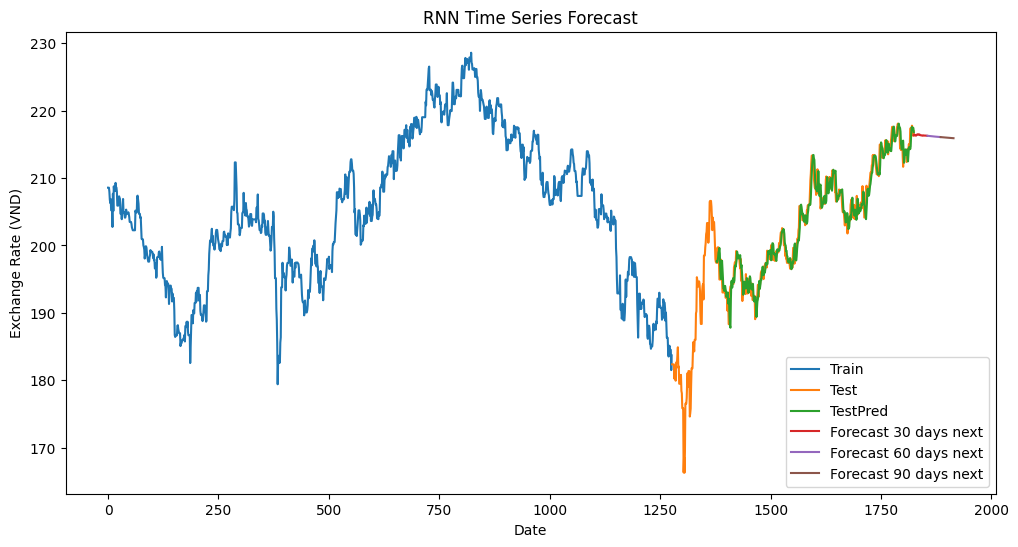

- Test: 
RMSE = 1.4898503667595462
MAPE = 0.5540573982792505
MAE = 1.127282809023307


In [14]:
implement_RNN(train_gbp_1_sc, test_gbp_1_sc)

- **Case 2. 8:2**

Epoch 1/100


C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0500 - val_loss: 0.0030
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0060 - val_loss: 0.0013
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - val_loss: 0.0011
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - val_loss: 9.1241e-04
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - val_loss: 0.0010
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014 - val_loss: 7.7240e-04
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0013 - val_loss: 8.5999e-04
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013 - val_loss: 7.9852e-04
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014 - val_loss: 7.7704e-04
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014 - val_loss: 6.2884e-04
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/st

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.7687e-04 - val_loss: 3.9396e-04
Epoch 66/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.6121e-04 - val_loss: 5.9902e-04
Epoch 67/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.3703e-04 - val_loss: 3.5802e-04
Epoch 68/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.1181e-04 - val_loss: 9.7889e-04
Epoch 69/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.4343e-04 - val_loss: 3.3044e-04
Epoch 70/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.1222e-04 - val_loss: 3.1813e-04
Epoch 71/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.9494e-04 - val_loss: 3.1585e-04
Epoch 72/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.1953e-04 - val_loss: 3.0291e-04
Epoch 73/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.8516e-04 - val_loss: 5.6193e-04
Epoch 74/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.6753e-04 - val_loss: 4.8595e-04
Epoch 75/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.2661e-04 

4 day output [[0.7745761]]
5 day input [0.73450723 0.75580126 0.75279825 0.75648376 0.75648376 0.75648376
 0.74979525 0.74105924 0.73027573 0.72167622 0.71048321 0.71048321
 0.71048321 0.71116571 0.71280371 0.70611521 0.74542725 0.78132678
 0.78132678 0.78132678 0.77354627 0.77764128 0.76180726 0.74938575
 0.75593776 0.75593776 0.75593776 0.75880426 0.76822277 0.78200928
 0.79183729 0.76535627 0.76535627 0.76535627 0.76931477 0.78924379
 0.75812176 0.78241878 0.76781327 0.76781327 0.76781327 0.76713077
 0.78692329 0.7959323  0.81094731 0.82350532 0.82350532 0.82350532
 0.80644281 0.79429429 0.78910729 0.8043953  0.8034398  0.8034398
 0.8034398  0.80985531 0.82295932 0.82555283 0.83114933 0.82241332
 0.82241332 0.82241332 0.80835381 0.77231777 0.78269178 0.76835927
 0.78883429 0.78883429 0.78883429 0.75279825 0.72836473 0.76194376
 0.76412776 0.76030576 0.76030576 0.76030576 0.76385476 0.76904177
 0.73983074 0.74406224 0.76999727 0.76999727 0.76999727 0.78228228
 0.76972427 0.77559378 0

13 day output [[0.7297622]]
14 day input [0.72167622 0.71048321 0.71048321 0.71048321 0.71116571 0.71280371
 0.70611521 0.74542725 0.78132678 0.78132678 0.78132678 0.77354627
 0.77764128 0.76180726 0.74938575 0.75593776 0.75593776 0.75593776
 0.75880426 0.76822277 0.78200928 0.79183729 0.76535627 0.76535627
 0.76535627 0.76931477 0.78924379 0.75812176 0.78241878 0.76781327
 0.76781327 0.76781327 0.76713077 0.78692329 0.7959323  0.81094731
 0.82350532 0.82350532 0.82350532 0.80644281 0.79429429 0.78910729
 0.8043953  0.8034398  0.8034398  0.8034398  0.80985531 0.82295932
 0.82555283 0.83114933 0.82241332 0.82241332 0.82241332 0.80835381
 0.77231777 0.78269178 0.76835927 0.78883429 0.78883429 0.78883429
 0.75279825 0.72836473 0.76194376 0.76412776 0.76030576 0.76030576
 0.76030576 0.76385476 0.76904177 0.73983074 0.74406224 0.76999727
 0.76999727 0.76999727 0.78228228 0.76972427 0.77559378 0.81927382
 0.82022932 0.82022932 0.82022932 0.82637183 0.82159432 0.8030303
 0.81572482 0.8030303 

23 day output [[0.68325925]]
24 day input [0.78132678 0.77354627 0.77764128 0.76180726 0.74938575 0.75593776
 0.75593776 0.75593776 0.75880426 0.76822277 0.78200928 0.79183729
 0.76535627 0.76535627 0.76535627 0.76931477 0.78924379 0.75812176
 0.78241878 0.76781327 0.76781327 0.76781327 0.76713077 0.78692329
 0.7959323  0.81094731 0.82350532 0.82350532 0.82350532 0.80644281
 0.79429429 0.78910729 0.8043953  0.8034398  0.8034398  0.8034398
 0.80985531 0.82295932 0.82555283 0.83114933 0.82241332 0.82241332
 0.82241332 0.80835381 0.77231777 0.78269178 0.76835927 0.78883429
 0.78883429 0.78883429 0.75279825 0.72836473 0.76194376 0.76412776
 0.76030576 0.76030576 0.76030576 0.76385476 0.76904177 0.73983074
 0.74406224 0.76999727 0.76999727 0.76999727 0.78228228 0.76972427
 0.77559378 0.81927382 0.82022932 0.82022932 0.82022932 0.82637183
 0.82159432 0.8030303  0.81572482 0.8030303  0.80129373 0.79624224
 0.78748614 0.78154063 0.77457613 0.77116847 0.76384807 0.75946885
 0.75712597 0.7518062

32 day output [[0.63886654]]
33 day input [0.76822277 0.78200928 0.79183729 0.76535627 0.76535627 0.76535627
 0.76931477 0.78924379 0.75812176 0.78241878 0.76781327 0.76781327
 0.76781327 0.76713077 0.78692329 0.7959323  0.81094731 0.82350532
 0.82350532 0.82350532 0.80644281 0.79429429 0.78910729 0.8043953
 0.8034398  0.8034398  0.8034398  0.80985531 0.82295932 0.82555283
 0.83114933 0.82241332 0.82241332 0.82241332 0.80835381 0.77231777
 0.78269178 0.76835927 0.78883429 0.78883429 0.78883429 0.75279825
 0.72836473 0.76194376 0.76412776 0.76030576 0.76030576 0.76030576
 0.76385476 0.76904177 0.73983074 0.74406224 0.76999727 0.76999727
 0.76999727 0.78228228 0.76972427 0.77559378 0.81927382 0.82022932
 0.82022932 0.82022932 0.82637183 0.82159432 0.8030303  0.81572482
 0.8030303  0.80129373 0.79624224 0.78748614 0.78154063 0.77457613
 0.77116847 0.76384807 0.75946885 0.75712597 0.75180626 0.74396938
 0.74024981 0.73594892 0.7297622  0.72628337 0.72083652 0.71618897
 0.7107873  0.7073584

40 day output [[0.5989833]]
41 day input [0.75812176 0.78241878 0.76781327 0.76781327 0.76781327 0.76713077
 0.78692329 0.7959323  0.81094731 0.82350532 0.82350532 0.82350532
 0.80644281 0.79429429 0.78910729 0.8043953  0.8034398  0.8034398
 0.8034398  0.80985531 0.82295932 0.82555283 0.83114933 0.82241332
 0.82241332 0.82241332 0.80835381 0.77231777 0.78269178 0.76835927
 0.78883429 0.78883429 0.78883429 0.75279825 0.72836473 0.76194376
 0.76412776 0.76030576 0.76030576 0.76030576 0.76385476 0.76904177
 0.73983074 0.74406224 0.76999727 0.76999727 0.76999727 0.78228228
 0.76972427 0.77559378 0.81927382 0.82022932 0.82022932 0.82022932
 0.82637183 0.82159432 0.8030303  0.81572482 0.8030303  0.80129373
 0.79624224 0.78748614 0.78154063 0.77457613 0.77116847 0.76384807
 0.75946885 0.75712597 0.75180626 0.74396938 0.74024981 0.73594892
 0.7297622  0.72628337 0.72083652 0.71618897 0.7107873  0.70735848
 0.70196438 0.69668645 0.69292992 0.68852079 0.68325925 0.67797607
 0.67320138 0.66780746

50 day output [[0.5513502]]
51 day input [0.82350532 0.82350532 0.80644281 0.79429429 0.78910729 0.8043953
 0.8034398  0.8034398  0.8034398  0.80985531 0.82295932 0.82555283
 0.83114933 0.82241332 0.82241332 0.82241332 0.80835381 0.77231777
 0.78269178 0.76835927 0.78883429 0.78883429 0.78883429 0.75279825
 0.72836473 0.76194376 0.76412776 0.76030576 0.76030576 0.76030576
 0.76385476 0.76904177 0.73983074 0.74406224 0.76999727 0.76999727
 0.76999727 0.78228228 0.76972427 0.77559378 0.81927382 0.82022932
 0.82022932 0.82022932 0.82637183 0.82159432 0.8030303  0.81572482
 0.8030303  0.80129373 0.79624224 0.78748614 0.78154063 0.77457613
 0.77116847 0.76384807 0.75946885 0.75712597 0.75180626 0.74396938
 0.74024981 0.73594892 0.7297622  0.72628337 0.72083652 0.71618897
 0.7107873  0.70735848 0.70196438 0.69668645 0.69292992 0.68852079
 0.68325925 0.67797607 0.67320138 0.66780746 0.66322982 0.65824097
 0.6534484  0.648444   0.64341307 0.63886654 0.63344336 0.62858039
 0.62377042 0.61874133

60 day output [[0.5051102]]
61 day input [0.82295932 0.82555283 0.83114933 0.82241332 0.82241332 0.82241332
 0.80835381 0.77231777 0.78269178 0.76835927 0.78883429 0.78883429
 0.78883429 0.75279825 0.72836473 0.76194376 0.76412776 0.76030576
 0.76030576 0.76030576 0.76385476 0.76904177 0.73983074 0.74406224
 0.76999727 0.76999727 0.76999727 0.78228228 0.76972427 0.77559378
 0.81927382 0.82022932 0.82022932 0.82022932 0.82637183 0.82159432
 0.8030303  0.81572482 0.8030303  0.80129373 0.79624224 0.78748614
 0.78154063 0.77457613 0.77116847 0.76384807 0.75946885 0.75712597
 0.75180626 0.74396938 0.74024981 0.73594892 0.7297622  0.72628337
 0.72083652 0.71618897 0.7107873  0.70735848 0.70196438 0.69668645
 0.69292992 0.68852079 0.68325925 0.67797607 0.67320138 0.66780746
 0.66322982 0.65824097 0.6534484  0.648444   0.64341307 0.63886654
 0.63344336 0.62858039 0.62377042 0.61874133 0.61364865 0.60886705
 0.60410357 0.59898329 0.59428811 0.5895955  0.58478457 0.57986087
 0.57522917 0.5703804

69 day output [[0.46565574]]
70 day input [0.76835927 0.78883429 0.78883429 0.78883429 0.75279825 0.72836473
 0.76194376 0.76412776 0.76030576 0.76030576 0.76030576 0.76385476
 0.76904177 0.73983074 0.74406224 0.76999727 0.76999727 0.76999727
 0.78228228 0.76972427 0.77559378 0.81927382 0.82022932 0.82022932
 0.82022932 0.82637183 0.82159432 0.8030303  0.81572482 0.8030303
 0.80129373 0.79624224 0.78748614 0.78154063 0.77457613 0.77116847
 0.76384807 0.75946885 0.75712597 0.75180626 0.74396938 0.74024981
 0.73594892 0.7297622  0.72628337 0.72083652 0.71618897 0.7107873
 0.70735848 0.70196438 0.69668645 0.69292992 0.68852079 0.68325925
 0.67797607 0.67320138 0.66780746 0.66322982 0.65824097 0.6534484
 0.648444   0.64341307 0.63886654 0.63344336 0.62858039 0.62377042
 0.61874133 0.61364865 0.60886705 0.60410357 0.59898329 0.59428811
 0.5895955  0.58478457 0.57986087 0.57522917 0.57038045 0.56545448
 0.56086272 0.55609584 0.55135018 0.54662305 0.54202193 0.53732628
 0.53261864 0.52804071 

79 day output [[0.42505983]]
80 day input [0.76030576 0.76385476 0.76904177 0.73983074 0.74406224 0.76999727
 0.76999727 0.76999727 0.78228228 0.76972427 0.77559378 0.81927382
 0.82022932 0.82022932 0.82022932 0.82637183 0.82159432 0.8030303
 0.81572482 0.8030303  0.80129373 0.79624224 0.78748614 0.78154063
 0.77457613 0.77116847 0.76384807 0.75946885 0.75712597 0.75180626
 0.74396938 0.74024981 0.73594892 0.7297622  0.72628337 0.72083652
 0.71618897 0.7107873  0.70735848 0.70196438 0.69668645 0.69292992
 0.68852079 0.68325925 0.67797607 0.67320138 0.66780746 0.66322982
 0.65824097 0.6534484  0.648444   0.64341307 0.63886654 0.63344336
 0.62858039 0.62377042 0.61874133 0.61364865 0.60886705 0.60410357
 0.59898329 0.59428811 0.5895955  0.58478457 0.57986087 0.57522917
 0.57038045 0.56545448 0.56086272 0.55609584 0.55135018 0.54662305
 0.54202193 0.53732628 0.53261864 0.52804071 0.52341622 0.51878989
 0.5142017  0.5097059  0.5051102  0.50059891 0.49616951 0.49170694
 0.48726985 0.4828844

89 day output [[0.3886818]]
90 day input [0.77559378 0.81927382 0.82022932 0.82022932 0.82022932 0.82637183
 0.82159432 0.8030303  0.81572482 0.8030303  0.80129373 0.79624224
 0.78748614 0.78154063 0.77457613 0.77116847 0.76384807 0.75946885
 0.75712597 0.75180626 0.74396938 0.74024981 0.73594892 0.7297622
 0.72628337 0.72083652 0.71618897 0.7107873  0.70735848 0.70196438
 0.69668645 0.69292992 0.68852079 0.68325925 0.67797607 0.67320138
 0.66780746 0.66322982 0.65824097 0.6534484  0.648444   0.64341307
 0.63886654 0.63344336 0.62858039 0.62377042 0.61874133 0.61364865
 0.60886705 0.60410357 0.59898329 0.59428811 0.5895955  0.58478457
 0.57986087 0.57522917 0.57038045 0.56545448 0.56086272 0.55609584
 0.55135018 0.54662305 0.54202193 0.53732628 0.53261864 0.52804071
 0.52341622 0.51878989 0.5142017  0.5097059  0.5051102  0.50059891
 0.49616951 0.49170694 0.48726985 0.48288444 0.47855967 0.47418001
 0.4698897  0.46565574 0.4614048  0.45720139 0.4530679  0.44895238
 0.4448429  0.44082034

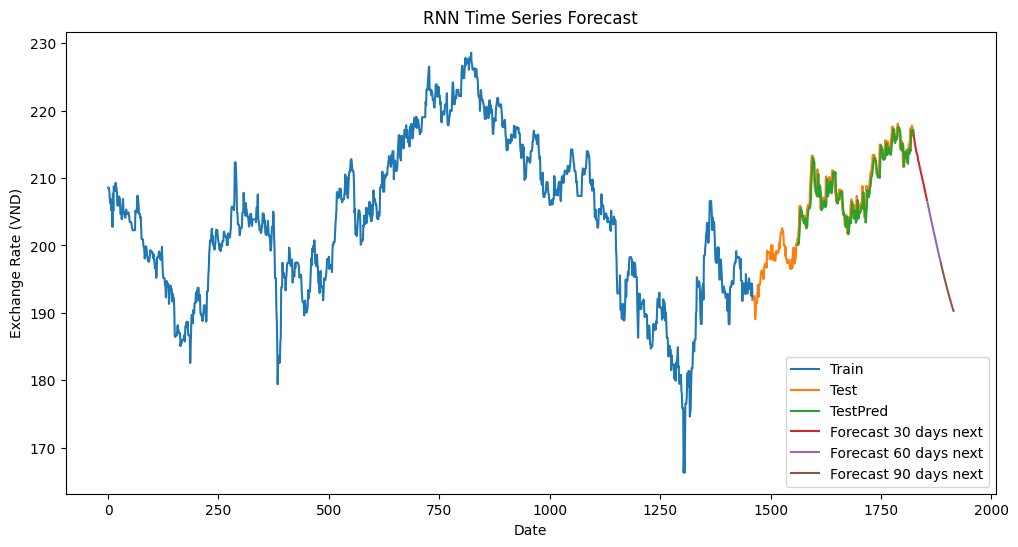

- Test: 
RMSE = 1.5295194592198473
MAPE = 0.561039505683212
MAE = 1.1764285509135355


In [15]:
implement_RNN(train_gbp_2_sc, test_gbp_2_sc)

- **Case 3. 9:1**

Epoch 1/100


C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0451 - val_loss: 0.0031
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0040 - val_loss: 0.0011
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026 - val_loss: 7.2172e-04
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0023 - val_loss: 8.2292e-04
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - val_loss: 7.7873e-04
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - val_loss: 7.5279e-04
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - val_loss: 5.9637e-04
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013 - val_loss: 8.5617e-04
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013 - val_loss: 5.4543e-04
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0012 - val_loss: 4.9521e-04
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7357e-04 - val_loss: 2.5678e-04
Epoch 66/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5208e-04 - val_loss: 3.8556e-04
Epoch 67/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.9191e-04 - val_loss: 5.5570e-04
Epoch 68/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.3811e-04 - val_loss: 5.3599e-04
Epoch 69/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.5766e-04 - val_loss: 2.4644e-04
Epoch 70/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3364e-04 - val_loss: 2.4489e-04
Epoch 71/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4814e-04 - val_loss: 5.5832e-04
Epoch 72/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.8554e-04 - val_loss: 3.0938e-04
Epoch 73/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.7501e-04 - val_loss: 4.2796e-04
Epoch 74/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.9339e-04 - val_loss: 2.4858e-04
Epoch 75/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.8065e-04 - 

5 day output [[0.75004494]]
6 day input [0.75580126 0.75279825 0.75648376 0.75648376 0.75648376 0.74979525
 0.74105924 0.73027573 0.72167622 0.71048321 0.71048321 0.71048321
 0.71116571 0.71280371 0.70611521 0.74542725 0.78132678 0.78132678
 0.78132678 0.77354627 0.77764128 0.76180726 0.74938575 0.75593776
 0.75593776 0.75593776 0.75880426 0.76822277 0.78200928 0.79183729
 0.76535627 0.76535627 0.76535627 0.76931477 0.78924379 0.75812176
 0.78241878 0.76781327 0.76781327 0.76781327 0.76713077 0.78692329
 0.7959323  0.81094731 0.82350532 0.82350532 0.82350532 0.80644281
 0.79429429 0.78910729 0.8043953  0.8034398  0.8034398  0.8034398
 0.80985531 0.82295932 0.82555283 0.83114933 0.82241332 0.82241332
 0.82241332 0.80835381 0.77231777 0.78269178 0.76835927 0.78883429
 0.78883429 0.78883429 0.75279825 0.72836473 0.76194376 0.76412776
 0.76030576 0.76030576 0.76030576 0.76385476 0.76904177 0.73983074
 0.74406224 0.76999727 0.76999727 0.76999727 0.78228228 0.76972427
 0.77559378 0.81927382 

13 day output [[0.68027323]]
14 day input [0.72167622 0.71048321 0.71048321 0.71048321 0.71116571 0.71280371
 0.70611521 0.74542725 0.78132678 0.78132678 0.78132678 0.77354627
 0.77764128 0.76180726 0.74938575 0.75593776 0.75593776 0.75593776
 0.75880426 0.76822277 0.78200928 0.79183729 0.76535627 0.76535627
 0.76535627 0.76931477 0.78924379 0.75812176 0.78241878 0.76781327
 0.76781327 0.76781327 0.76713077 0.78692329 0.7959323  0.81094731
 0.82350532 0.82350532 0.82350532 0.80644281 0.79429429 0.78910729
 0.8043953  0.8034398  0.8034398  0.8034398  0.80985531 0.82295932
 0.82555283 0.83114933 0.82241332 0.82241332 0.82241332 0.80835381
 0.77231777 0.78269178 0.76835927 0.78883429 0.78883429 0.78883429
 0.75279825 0.72836473 0.76194376 0.76412776 0.76030576 0.76030576
 0.76030576 0.76385476 0.76904177 0.73983074 0.74406224 0.76999727
 0.76999727 0.76999727 0.78228228 0.76972427 0.77559378 0.81927382
 0.82022932 0.82022932 0.82022932 0.82637183 0.82159432 0.8030303
 0.81572482 0.8030303

23 day output [[0.59097064]]
24 day input [0.78132678 0.77354627 0.77764128 0.76180726 0.74938575 0.75593776
 0.75593776 0.75593776 0.75880426 0.76822277 0.78200928 0.79183729
 0.76535627 0.76535627 0.76535627 0.76931477 0.78924379 0.75812176
 0.78241878 0.76781327 0.76781327 0.76781327 0.76713077 0.78692329
 0.7959323  0.81094731 0.82350532 0.82350532 0.82350532 0.80644281
 0.79429429 0.78910729 0.8043953  0.8034398  0.8034398  0.8034398
 0.80985531 0.82295932 0.82555283 0.83114933 0.82241332 0.82241332
 0.82241332 0.80835381 0.77231777 0.78269178 0.76835927 0.78883429
 0.78883429 0.78883429 0.75279825 0.72836473 0.76194376 0.76412776
 0.76030576 0.76030576 0.76030576 0.76385476 0.76904177 0.73983074
 0.74406224 0.76999727 0.76999727 0.76999727 0.78228228 0.76972427
 0.77559378 0.81927382 0.82022932 0.82022932 0.82022932 0.82637183
 0.82159432 0.8030303  0.81572482 0.8030303  0.79480749 0.78988695
 0.78122556 0.76902378 0.75752383 0.75004494 0.74240756 0.73514664
 0.72742051 0.7179919

33 day output [[0.5047062]]
34 day input [0.78200928 0.79183729 0.76535627 0.76535627 0.76535627 0.76931477
 0.78924379 0.75812176 0.78241878 0.76781327 0.76781327 0.76781327
 0.76713077 0.78692329 0.7959323  0.81094731 0.82350532 0.82350532
 0.82350532 0.80644281 0.79429429 0.78910729 0.8043953  0.8034398
 0.8034398  0.8034398  0.80985531 0.82295932 0.82555283 0.83114933
 0.82241332 0.82241332 0.82241332 0.80835381 0.77231777 0.78269178
 0.76835927 0.78883429 0.78883429 0.78883429 0.75279825 0.72836473
 0.76194376 0.76412776 0.76030576 0.76030576 0.76030576 0.76385476
 0.76904177 0.73983074 0.74406224 0.76999727 0.76999727 0.76999727
 0.78228228 0.76972427 0.77559378 0.81927382 0.82022932 0.82022932
 0.82022932 0.82637183 0.82159432 0.8030303  0.81572482 0.8030303
 0.79480749 0.78988695 0.78122556 0.76902378 0.75752383 0.75004494
 0.74240756 0.73514664 0.72742051 0.71799195 0.70638335 0.69721115
 0.68888748 0.68027323 0.67173165 0.6630066  0.6555317  0.6453349
 0.63478577 0.6258772  0

43 day output [[0.430141]]
44 day input [0.76781327 0.76781327 0.76713077 0.78692329 0.7959323  0.81094731
 0.82350532 0.82350532 0.82350532 0.80644281 0.79429429 0.78910729
 0.8043953  0.8034398  0.8034398  0.8034398  0.80985531 0.82295932
 0.82555283 0.83114933 0.82241332 0.82241332 0.82241332 0.80835381
 0.77231777 0.78269178 0.76835927 0.78883429 0.78883429 0.78883429
 0.75279825 0.72836473 0.76194376 0.76412776 0.76030576 0.76030576
 0.76030576 0.76385476 0.76904177 0.73983074 0.74406224 0.76999727
 0.76999727 0.76999727 0.78228228 0.76972427 0.77559378 0.81927382
 0.82022932 0.82022932 0.82022932 0.82637183 0.82159432 0.8030303
 0.81572482 0.8030303  0.79480749 0.78988695 0.78122556 0.76902378
 0.75752383 0.75004494 0.74240756 0.73514664 0.72742051 0.71799195
 0.70638335 0.69721115 0.68888748 0.68027323 0.67173165 0.6630066
 0.6555317  0.6453349  0.63478577 0.6258772  0.61749887 0.60896122
 0.60014284 0.59097064 0.58133763 0.5719384  0.56388241 0.55520636
 0.54611701 0.53798425 0

53 day output [[0.3709208]]
54 day input [0.79429429 0.78910729 0.8043953  0.8034398  0.8034398  0.8034398
 0.80985531 0.82295932 0.82555283 0.83114933 0.82241332 0.82241332
 0.82241332 0.80835381 0.77231777 0.78269178 0.76835927 0.78883429
 0.78883429 0.78883429 0.75279825 0.72836473 0.76194376 0.76412776
 0.76030576 0.76030576 0.76030576 0.76385476 0.76904177 0.73983074
 0.74406224 0.76999727 0.76999727 0.76999727 0.78228228 0.76972427
 0.77559378 0.81927382 0.82022932 0.82022932 0.82022932 0.82637183
 0.82159432 0.8030303  0.81572482 0.8030303  0.79480749 0.78988695
 0.78122556 0.76902378 0.75752383 0.75004494 0.74240756 0.73514664
 0.72742051 0.71799195 0.70638335 0.69721115 0.68888748 0.68027323
 0.67173165 0.6630066  0.6555317  0.6453349  0.63478577 0.6258772
 0.61749887 0.60896122 0.60014284 0.59097064 0.58133763 0.5719384
 0.56388241 0.55520636 0.54611701 0.53798425 0.52962446 0.52075571
 0.51253229 0.5047062  0.49640122 0.4884471  0.48096296 0.47312337
 0.46519738 0.45826703 0

63 day output [[0.3251556]]
64 day input [0.82241332 0.82241332 0.82241332 0.80835381 0.77231777 0.78269178
 0.76835927 0.78883429 0.78883429 0.78883429 0.75279825 0.72836473
 0.76194376 0.76412776 0.76030576 0.76030576 0.76030576 0.76385476
 0.76904177 0.73983074 0.74406224 0.76999727 0.76999727 0.76999727
 0.78228228 0.76972427 0.77559378 0.81927382 0.82022932 0.82022932
 0.82022932 0.82637183 0.82159432 0.8030303  0.81572482 0.8030303
 0.79480749 0.78988695 0.78122556 0.76902378 0.75752383 0.75004494
 0.74240756 0.73514664 0.72742051 0.71799195 0.70638335 0.69721115
 0.68888748 0.68027323 0.67173165 0.6630066  0.6555317  0.6453349
 0.63478577 0.6258772  0.61749887 0.60896122 0.60014284 0.59097064
 0.58133763 0.5719384  0.56388241 0.55520636 0.54611701 0.53798425
 0.52962446 0.52075571 0.51253229 0.5047062  0.49640122 0.4884471
 0.48096296 0.47312337 0.46519738 0.45826703 0.45129687 0.44386193
 0.43686777 0.430141   0.42333677 0.41699749 0.41109025 0.40474418
 0.39836892 0.39259848 0

73 day output [[0.29157984]]
74 day input [0.75279825 0.72836473 0.76194376 0.76412776 0.76030576 0.76030576
 0.76030576 0.76385476 0.76904177 0.73983074 0.74406224 0.76999727
 0.76999727 0.76999727 0.78228228 0.76972427 0.77559378 0.81927382
 0.82022932 0.82022932 0.82022932 0.82637183 0.82159432 0.8030303
 0.81572482 0.8030303  0.79480749 0.78988695 0.78122556 0.76902378
 0.75752383 0.75004494 0.74240756 0.73514664 0.72742051 0.71799195
 0.70638335 0.69721115 0.68888748 0.68027323 0.67173165 0.6630066
 0.6555317  0.6453349  0.63478577 0.6258772  0.61749887 0.60896122
 0.60014284 0.59097064 0.58133763 0.5719384  0.56388241 0.55520636
 0.54611701 0.53798425 0.52962446 0.52075571 0.51253229 0.5047062
 0.49640122 0.4884471  0.48096296 0.47312337 0.46519738 0.45826703
 0.45129687 0.44386193 0.43686777 0.430141   0.42333677 0.41699749
 0.41109025 0.40474418 0.39836892 0.39259848 0.38698682 0.38136199
 0.37606898 0.37092081 0.36560255 0.36050564 0.35569614 0.35092971
 0.34633037 0.34201479 

83 day output [[0.26805747]]
84 day input [0.74406224 0.76999727 0.76999727 0.76999727 0.78228228 0.76972427
 0.77559378 0.81927382 0.82022932 0.82022932 0.82022932 0.82637183
 0.82159432 0.8030303  0.81572482 0.8030303  0.79480749 0.78988695
 0.78122556 0.76902378 0.75752383 0.75004494 0.74240756 0.73514664
 0.72742051 0.71799195 0.70638335 0.69721115 0.68888748 0.68027323
 0.67173165 0.6630066  0.6555317  0.6453349  0.63478577 0.6258772
 0.61749887 0.60896122 0.60014284 0.59097064 0.58133763 0.5719384
 0.56388241 0.55520636 0.54611701 0.53798425 0.52962446 0.52075571
 0.51253229 0.5047062  0.49640122 0.4884471  0.48096296 0.47312337
 0.46519738 0.45826703 0.45129687 0.44386193 0.43686777 0.430141
 0.42333677 0.41699749 0.41109025 0.40474418 0.39836892 0.39259848
 0.38698682 0.38136199 0.37606898 0.37092081 0.36560255 0.36050564
 0.35569614 0.35092971 0.34633037 0.34201479 0.33769524 0.33329582
 0.3290638  0.32515559 0.32144123 0.31775138 0.31406918 0.31045377
 0.30696255 0.30368224 0

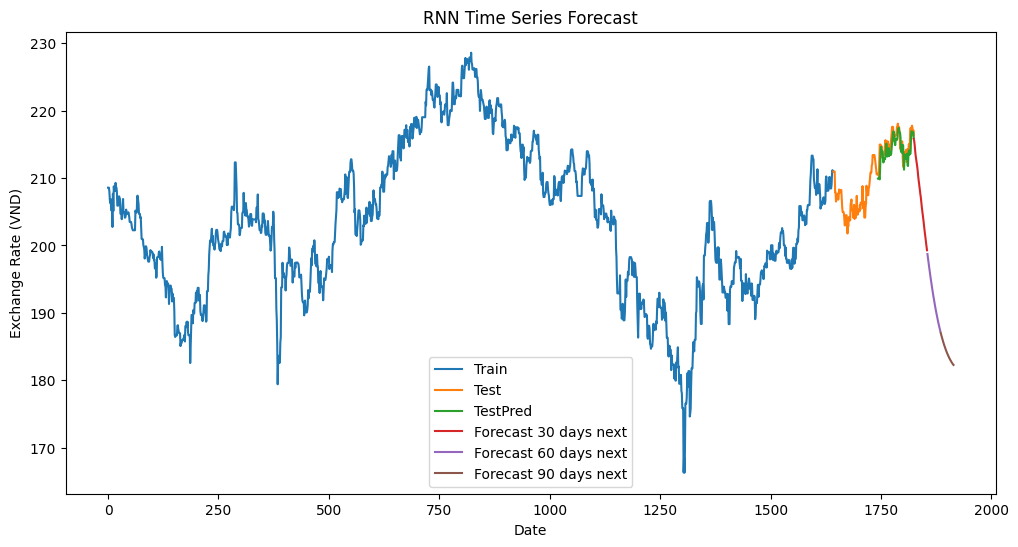

- Test: 
RMSE = 1.5259575022361107
MAPE = 0.5463513015254968
MAE = 1.1754911108667077


In [16]:
implement_RNN(train_gbp_3_sc, test_gbp_3_sc)

# JPY - VND

- **Case 1. 7:3**

Epoch 1/100


C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.1236 - val_loss: 0.0043
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - val_loss: 0.0070
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.1167e-04 - val_loss: 0.0012
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.7559e-04 - val_loss: 0.0010
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.4778e-04 - val_loss: 9.4970e-04
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.6886e-04 - val_loss: 8.8112e-04
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.1906e-04 - val_loss: 8.0217e-04
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.6057e-04 - val_loss: 7.8089e-04
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.7957e-04 - val_loss: 7.5159e-04
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.0499e-04 - val_loss: 7.3960e-04
Epoch 12

Epoch 65/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6196e-04 - val_loss: 3.9961e-04
Epoch 66/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.9817e-04 - val_loss: 4.3842e-04
Epoch 67/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.3904e-04 - val_loss: 4.5328e-04
Epoch 68/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.5966e-04 - val_loss: 3.8696e-04
Epoch 69/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.5887e-04 - val_loss: 4.7979e-04
Epoch 70/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.6491e-04 - val_loss: 4.0449e-04
Epoch 71/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.2174e-04 - val_loss: 3.9755e-04
Epoch 72/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.8610e-04 - val_loss: 3.9681e-04
Epoch 73/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.1115e-04 - val_loss: 3.8230e-04
Epoch 74/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.5543e-04 - val_loss: 4.2290e-04
Epoch 75/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/st

4 day output [[0.08324166]]
5 day input [0.04139259 0.06160757 0.06898765 0.0612867  0.0612867  0.0612867
 0.07684903 0.07091288 0.06866677 0.10717151 0.12000642 0.12000642
 0.12000642 0.08471041 0.10075405 0.09337398 0.17182737 0.17054388
 0.17054388 0.17054388 0.16877908 0.13043478 0.14631798 0.15129151
 0.15963421 0.15963421 0.15963421 0.15754853 0.16348468 0.16300337
 0.18626665 0.17006257 0.17006257 0.17006257 0.18305792 0.18145355
 0.16781646 0.14310926 0.11856249 0.11856249 0.11856249 0.12754693
 0.1384566  0.12642387 0.12145034 0.13396438 0.13396438 0.13396438
 0.12112947 0.11070111 0.08406867 0.08535216 0.08390823 0.08390823
 0.08390823 0.08214343 0.09112787 0.09898925 0.09754532 0.09401572
 0.09401572 0.09401572 0.08615434 0.07781165 0.08118081 0.08968394
 0.08454998 0.08454998 0.08454998 0.05647361 0.0524627  0.07059201
 0.05888015 0.04684742 0.04684742 0.04684742 0.0506979  0.04251564
 0.02583026 0.03818386 0.0454035  0.0454035  0.0454035  0.04957484
 0.04219477 0.04524306 

14 day output [[0.13140996]]
15 day input [0.12000642 0.12000642 0.12000642 0.08471041 0.10075405 0.09337398
 0.17182737 0.17054388 0.17054388 0.17054388 0.16877908 0.13043478
 0.14631798 0.15129151 0.15963421 0.15963421 0.15963421 0.15754853
 0.16348468 0.16300337 0.18626665 0.17006257 0.17006257 0.17006257
 0.18305792 0.18145355 0.16781646 0.14310926 0.11856249 0.11856249
 0.11856249 0.12754693 0.1384566  0.12642387 0.12145034 0.13396438
 0.13396438 0.13396438 0.12112947 0.11070111 0.08406867 0.08535216
 0.08390823 0.08390823 0.08390823 0.08214343 0.09112787 0.09898925
 0.09754532 0.09401572 0.09401572 0.09401572 0.08615434 0.07781165
 0.08118081 0.08968394 0.08454998 0.08454998 0.08454998 0.05647361
 0.0524627  0.07059201 0.05888015 0.04684742 0.04684742 0.04684742
 0.0506979  0.04251564 0.02583026 0.03818386 0.0454035  0.0454035
 0.0454035  0.04957484 0.04219477 0.04524306 0.05053746 0.04989572
 0.04989572 0.04989572 0.05519012 0.05310444 0.04412001 0.06369325
 0.04700786 0.063824 

22 day output [[0.15817082]]
23 day input [0.17054388 0.17054388 0.16877908 0.13043478 0.14631798 0.15129151
 0.15963421 0.15963421 0.15963421 0.15754853 0.16348468 0.16300337
 0.18626665 0.17006257 0.17006257 0.17006257 0.18305792 0.18145355
 0.16781646 0.14310926 0.11856249 0.11856249 0.11856249 0.12754693
 0.1384566  0.12642387 0.12145034 0.13396438 0.13396438 0.13396438
 0.12112947 0.11070111 0.08406867 0.08535216 0.08390823 0.08390823
 0.08390823 0.08214343 0.09112787 0.09898925 0.09754532 0.09401572
 0.09401572 0.09401572 0.08615434 0.07781165 0.08118081 0.08968394
 0.08454998 0.08454998 0.08454998 0.05647361 0.0524627  0.07059201
 0.05888015 0.04684742 0.04684742 0.04684742 0.0506979  0.04251564
 0.02583026 0.03818386 0.0454035  0.0454035  0.0454035  0.04957484
 0.04219477 0.04524306 0.05053746 0.04989572 0.04989572 0.04989572
 0.05519012 0.05310444 0.04412001 0.06369325 0.04700786 0.063824
 0.06485353 0.07214911 0.07678758 0.08324166 0.08751234 0.09474502
 0.09972927 0.10288029

30 day output [[0.17904922]]
31 day input [0.15963421 0.15754853 0.16348468 0.16300337 0.18626665 0.17006257
 0.17006257 0.17006257 0.18305792 0.18145355 0.16781646 0.14310926
 0.11856249 0.11856249 0.11856249 0.12754693 0.1384566  0.12642387
 0.12145034 0.13396438 0.13396438 0.13396438 0.12112947 0.11070111
 0.08406867 0.08535216 0.08390823 0.08390823 0.08390823 0.08214343
 0.09112787 0.09898925 0.09754532 0.09401572 0.09401572 0.09401572
 0.08615434 0.07781165 0.08118081 0.08968394 0.08454998 0.08454998
 0.08454998 0.05647361 0.0524627  0.07059201 0.05888015 0.04684742
 0.04684742 0.04684742 0.0506979  0.04251564 0.02583026 0.03818386
 0.0454035  0.0454035  0.0454035  0.04957484 0.04219477 0.04524306
 0.05053746 0.04989572 0.04989572 0.04989572 0.05519012 0.05310444
 0.04412001 0.06369325 0.04700786 0.063824   0.06485353 0.07214911
 0.07678758 0.08324166 0.08751234 0.09474502 0.09972927 0.10288029
 0.1091778  0.11213599 0.11770895 0.1216618  0.12519011 0.13140996
 0.13288023 0.138828

38 day output [[0.19093433]]
39 day input [0.18305792 0.18145355 0.16781646 0.14310926 0.11856249 0.11856249
 0.11856249 0.12754693 0.1384566  0.12642387 0.12145034 0.13396438
 0.13396438 0.13396438 0.12112947 0.11070111 0.08406867 0.08535216
 0.08390823 0.08390823 0.08390823 0.08214343 0.09112787 0.09898925
 0.09754532 0.09401572 0.09401572 0.09401572 0.08615434 0.07781165
 0.08118081 0.08968394 0.08454998 0.08454998 0.08454998 0.05647361
 0.0524627  0.07059201 0.05888015 0.04684742 0.04684742 0.04684742
 0.0506979  0.04251564 0.02583026 0.03818386 0.0454035  0.0454035
 0.0454035  0.04957484 0.04219477 0.04524306 0.05053746 0.04989572
 0.04989572 0.04989572 0.05519012 0.05310444 0.04412001 0.06369325
 0.04700786 0.063824   0.06485353 0.07214911 0.07678758 0.08324166
 0.08751234 0.09474502 0.09972927 0.10288029 0.1091778  0.11213599
 0.11770895 0.1216618  0.12519011 0.13140996 0.13288023 0.13882896
 0.1412375  0.14453016 0.14851014 0.15216085 0.15522221 0.15817082
 0.16099557 0.1638674

48 day output [[0.19761057]]
49 day input [0.12145034 0.13396438 0.13396438 0.13396438 0.12112947 0.11070111
 0.08406867 0.08535216 0.08390823 0.08390823 0.08390823 0.08214343
 0.09112787 0.09898925 0.09754532 0.09401572 0.09401572 0.09401572
 0.08615434 0.07781165 0.08118081 0.08968394 0.08454998 0.08454998
 0.08454998 0.05647361 0.0524627  0.07059201 0.05888015 0.04684742
 0.04684742 0.04684742 0.0506979  0.04251564 0.02583026 0.03818386
 0.0454035  0.0454035  0.0454035  0.04957484 0.04219477 0.04524306
 0.05053746 0.04989572 0.04989572 0.04989572 0.05519012 0.05310444
 0.04412001 0.06369325 0.04700786 0.063824   0.06485353 0.07214911
 0.07678758 0.08324166 0.08751234 0.09474502 0.09972927 0.10288029
 0.1091778  0.11213599 0.11770895 0.1216618  0.12519011 0.13140996
 0.13288023 0.13882896 0.1412375  0.14453016 0.14851014 0.15216085
 0.15522221 0.15817082 0.16099557 0.16386747 0.16735342 0.16897188
 0.17209268 0.17432001 0.17621811 0.17904922 0.180408   0.1825283
 0.18423849 0.1855579

56 day output [[0.1988477]]
57 day input [0.08390823 0.08390823 0.08390823 0.08214343 0.09112787 0.09898925
 0.09754532 0.09401572 0.09401572 0.09401572 0.08615434 0.07781165
 0.08118081 0.08968394 0.08454998 0.08454998 0.08454998 0.05647361
 0.0524627  0.07059201 0.05888015 0.04684742 0.04684742 0.04684742
 0.0506979  0.04251564 0.02583026 0.03818386 0.0454035  0.0454035
 0.0454035  0.04957484 0.04219477 0.04524306 0.05053746 0.04989572
 0.04989572 0.04989572 0.05519012 0.05310444 0.04412001 0.06369325
 0.04700786 0.063824   0.06485353 0.07214911 0.07678758 0.08324166
 0.08751234 0.09474502 0.09972927 0.10288029 0.1091778  0.11213599
 0.11770895 0.1216618  0.12519011 0.13140996 0.13288023 0.13882896
 0.1412375  0.14453016 0.14851014 0.15216085 0.15522221 0.15817082
 0.16099557 0.16386747 0.16735342 0.16897188 0.17209268 0.17432001
 0.17621811 0.17904922 0.180408   0.1825283  0.18423849 0.18555793
 0.18764897 0.18843    0.18999319 0.19093433 0.19195978 0.19285907
 0.19380677 0.19440469

66 day output [[0.19913085]]
67 day input [0.08615434 0.07781165 0.08118081 0.08968394 0.08454998 0.08454998
 0.08454998 0.05647361 0.0524627  0.07059201 0.05888015 0.04684742
 0.04684742 0.04684742 0.0506979  0.04251564 0.02583026 0.03818386
 0.0454035  0.0454035  0.0454035  0.04957484 0.04219477 0.04524306
 0.05053746 0.04989572 0.04989572 0.04989572 0.05519012 0.05310444
 0.04412001 0.06369325 0.04700786 0.063824   0.06485353 0.07214911
 0.07678758 0.08324166 0.08751234 0.09474502 0.09972927 0.10288029
 0.1091778  0.11213599 0.11770895 0.1216618  0.12519011 0.13140996
 0.13288023 0.13882896 0.1412375  0.14453016 0.14851014 0.15216085
 0.15522221 0.15817082 0.16099557 0.16386747 0.16735342 0.16897188
 0.17209268 0.17432001 0.17621811 0.17904922 0.180408   0.1825283
 0.18423849 0.18555793 0.18764897 0.18843    0.18999319 0.19093433
 0.19195978 0.19285907 0.19380677 0.19440469 0.19517891 0.19573756
 0.19634236 0.19696869 0.19720238 0.19761057 0.19792099 0.19803163
 0.19840382 0.1983372

76 day output [[0.19794628]]
77 day input [0.05888015 0.04684742 0.04684742 0.04684742 0.0506979  0.04251564
 0.02583026 0.03818386 0.0454035  0.0454035  0.0454035  0.04957484
 0.04219477 0.04524306 0.05053746 0.04989572 0.04989572 0.04989572
 0.05519012 0.05310444 0.04412001 0.06369325 0.04700786 0.063824
 0.06485353 0.07214911 0.07678758 0.08324166 0.08751234 0.09474502
 0.09972927 0.10288029 0.1091778  0.11213599 0.11770895 0.1216618
 0.12519011 0.13140996 0.13288023 0.13882896 0.1412375  0.14453016
 0.14851014 0.15216085 0.15522221 0.15817082 0.16099557 0.16386747
 0.16735342 0.16897188 0.17209268 0.17432001 0.17621811 0.17904922
 0.180408   0.1825283  0.18423849 0.18555793 0.18764897 0.18843
 0.18999319 0.19093433 0.19195978 0.19285907 0.19380677 0.19440469
 0.19517891 0.19573756 0.19634236 0.19696869 0.19720238 0.19761057
 0.19792099 0.19803163 0.19840382 0.1983372  0.198571   0.19859396
 0.19869542 0.1988477  0.19890103 0.19896258 0.19903971 0.19913341
 0.19919555 0.19922511 0.1

85 day output [[0.19622956]]
86 day input [0.0454035  0.0454035  0.04957484 0.04219477 0.04524306 0.05053746
 0.04989572 0.04989572 0.04989572 0.05519012 0.05310444 0.04412001
 0.06369325 0.04700786 0.063824   0.06485353 0.07214911 0.07678758
 0.08324166 0.08751234 0.09474502 0.09972927 0.10288029 0.1091778
 0.11213599 0.11770895 0.1216618  0.12519011 0.13140996 0.13288023
 0.13882896 0.1412375  0.14453016 0.14851014 0.15216085 0.15522221
 0.15817082 0.16099557 0.16386747 0.16735342 0.16897188 0.17209268
 0.17432001 0.17621811 0.17904922 0.180408   0.1825283  0.18423849
 0.18555793 0.18764897 0.18843    0.18999319 0.19093433 0.19195978
 0.19285907 0.19380677 0.19440469 0.19517891 0.19573756 0.19634236
 0.19696869 0.19720238 0.19761057 0.19792099 0.19803163 0.19840382
 0.1983372  0.198571   0.19859396 0.19869542 0.1988477  0.19890103
 0.19896258 0.19903971 0.19913341 0.19919555 0.19922511 0.19917019
 0.19919205 0.19920093 0.19913085 0.19909768 0.19895878 0.19893497
 0.19880128 0.1986612

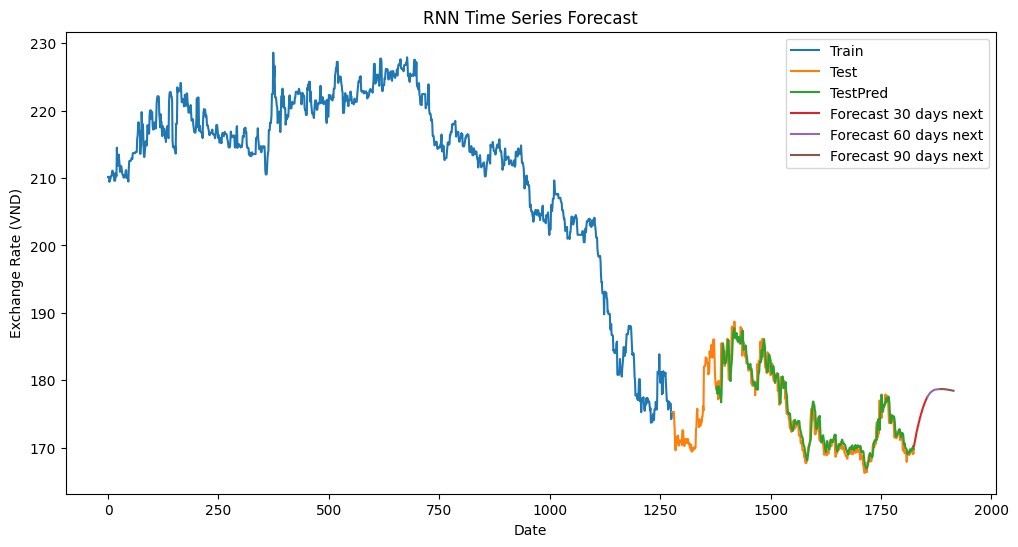

- Test: 
RMSE = 1.4913317928054686
MAPE = 0.6097917339472916
MAE = 1.0736258446610216


In [17]:
implement_RNN(train_jpy_1_sc, test_jpy_1_sc)

- **Case 2. 8:2**

Epoch 1/100


C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0732 - val_loss: 0.0032
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011 - val_loss: 8.0766e-04
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.7111e-04 - val_loss: 6.3293e-04
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.7205e-04 - val_loss: 5.0254e-04
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.5680e-04 - val_loss: 4.7628e-04
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.6425e-04 - val_loss: 4.5516e-04
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.5478e-04 - val_loss: 4.5401e-04
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.2748e-04 - val_loss: 6.0826e-04
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.4091e-04 - val_loss: 3.4050e-04
Epoch 12/100

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.6922e-04 - val_loss: 3.4047e-04
Epoch 66/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.6065e-04 - val_loss: 3.1548e-04
Epoch 67/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.6276e-04 - val_loss: 2.7129e-04
Epoch 68/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.6834e-04 - val_loss: 1.9904e-04
Epoch 69/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.1421e-04 - val_loss: 1.9221e-04
Epoch 70/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.1485e-04 - val_loss: 2.6769e-04
Epoch 71/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.1052e-04 - val_loss: 1.9297e-04
Epoch 72/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.6167e-04 - val_loss: 2.5439e-04
Epoch 73/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.3797e-04 - val_loss: 1.9211e-04
Epoch 74/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.2624e-04 - val_loss: 1.9246e-04
Epoch 75/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.1098e-04 - 

5 day output [[0.08895624]]
6 day input [0.06160757 0.06898765 0.0612867  0.0612867  0.0612867  0.07684903
 0.07091288 0.06866677 0.10717151 0.12000642 0.12000642 0.12000642
 0.08471041 0.10075405 0.09337398 0.17182737 0.17054388 0.17054388
 0.17054388 0.16877908 0.13043478 0.14631798 0.15129151 0.15963421
 0.15963421 0.15963421 0.15754853 0.16348468 0.16300337 0.18626665
 0.17006257 0.17006257 0.17006257 0.18305792 0.18145355 0.16781646
 0.14310926 0.11856249 0.11856249 0.11856249 0.12754693 0.1384566
 0.12642387 0.12145034 0.13396438 0.13396438 0.13396438 0.12112947
 0.11070111 0.08406867 0.08535216 0.08390823 0.08390823 0.08390823
 0.08214343 0.09112787 0.09898925 0.09754532 0.09401572 0.09401572
 0.09401572 0.08615434 0.07781165 0.08118081 0.08968394 0.08454998
 0.08454998 0.08454998 0.05647361 0.0524627  0.07059201 0.05888015
 0.04684742 0.04684742 0.04684742 0.0506979  0.04251564 0.02583026
 0.03818386 0.0454035  0.0454035  0.0454035  0.04957484 0.04219477
 0.04524306 0.05053746 

15 day output [[0.16305646]]
16 day input [0.12000642 0.12000642 0.08471041 0.10075405 0.09337398 0.17182737
 0.17054388 0.17054388 0.17054388 0.16877908 0.13043478 0.14631798
 0.15129151 0.15963421 0.15963421 0.15963421 0.15754853 0.16348468
 0.16300337 0.18626665 0.17006257 0.17006257 0.17006257 0.18305792
 0.18145355 0.16781646 0.14310926 0.11856249 0.11856249 0.11856249
 0.12754693 0.1384566  0.12642387 0.12145034 0.13396438 0.13396438
 0.13396438 0.12112947 0.11070111 0.08406867 0.08535216 0.08390823
 0.08390823 0.08390823 0.08214343 0.09112787 0.09898925 0.09754532
 0.09401572 0.09401572 0.09401572 0.08615434 0.07781165 0.08118081
 0.08968394 0.08454998 0.08454998 0.08454998 0.05647361 0.0524627
 0.07059201 0.05888015 0.04684742 0.04684742 0.04684742 0.0506979
 0.04251564 0.02583026 0.03818386 0.0454035  0.0454035  0.0454035
 0.04957484 0.04219477 0.04524306 0.05053746 0.04989572 0.04989572
 0.04989572 0.05519012 0.05310444 0.04412001 0.06369325 0.04700786
 0.06127926 0.06289737 

25 day output [[0.19955336]]
26 day input [0.13043478 0.14631798 0.15129151 0.15963421 0.15963421 0.15963421
 0.15754853 0.16348468 0.16300337 0.18626665 0.17006257 0.17006257
 0.17006257 0.18305792 0.18145355 0.16781646 0.14310926 0.11856249
 0.11856249 0.11856249 0.12754693 0.1384566  0.12642387 0.12145034
 0.13396438 0.13396438 0.13396438 0.12112947 0.11070111 0.08406867
 0.08535216 0.08390823 0.08390823 0.08390823 0.08214343 0.09112787
 0.09898925 0.09754532 0.09401572 0.09401572 0.09401572 0.08615434
 0.07781165 0.08118081 0.08968394 0.08454998 0.08454998 0.08454998
 0.05647361 0.0524627  0.07059201 0.05888015 0.04684742 0.04684742
 0.04684742 0.0506979  0.04251564 0.02583026 0.03818386 0.0454035
 0.0454035  0.0454035  0.04957484 0.04219477 0.04524306 0.05053746
 0.04989572 0.04989572 0.04989572 0.05519012 0.05310444 0.04412001
 0.06369325 0.04700786 0.06127926 0.06289737 0.07312944 0.07436591
 0.08089947 0.08895624 0.09203746 0.09983435 0.10264251 0.11033545
 0.12279752 0.1414388

35 day output [[0.22200866]]
36 day input [0.17006257 0.17006257 0.17006257 0.18305792 0.18145355 0.16781646
 0.14310926 0.11856249 0.11856249 0.11856249 0.12754693 0.1384566
 0.12642387 0.12145034 0.13396438 0.13396438 0.13396438 0.12112947
 0.11070111 0.08406867 0.08535216 0.08390823 0.08390823 0.08390823
 0.08214343 0.09112787 0.09898925 0.09754532 0.09401572 0.09401572
 0.09401572 0.08615434 0.07781165 0.08118081 0.08968394 0.08454998
 0.08454998 0.08454998 0.05647361 0.0524627  0.07059201 0.05888015
 0.04684742 0.04684742 0.04684742 0.0506979  0.04251564 0.02583026
 0.03818386 0.0454035  0.0454035  0.0454035  0.04957484 0.04219477
 0.04524306 0.05053746 0.04989572 0.04989572 0.04989572 0.05519012
 0.05310444 0.04412001 0.06369325 0.04700786 0.06127926 0.06289737
 0.07312944 0.07436591 0.08089947 0.08895624 0.09203746 0.09983435
 0.10264251 0.11033545 0.12279752 0.1414388  0.14326777 0.15450692
 0.15839723 0.16305646 0.16588351 0.1707018  0.16882226 0.17170841
 0.17621204 0.1810655

45 day output [[0.23632687]]
46 day input [0.12754693 0.1384566  0.12642387 0.12145034 0.13396438 0.13396438
 0.13396438 0.12112947 0.11070111 0.08406867 0.08535216 0.08390823
 0.08390823 0.08390823 0.08214343 0.09112787 0.09898925 0.09754532
 0.09401572 0.09401572 0.09401572 0.08615434 0.07781165 0.08118081
 0.08968394 0.08454998 0.08454998 0.08454998 0.05647361 0.0524627
 0.07059201 0.05888015 0.04684742 0.04684742 0.04684742 0.0506979
 0.04251564 0.02583026 0.03818386 0.0454035  0.0454035  0.0454035
 0.04957484 0.04219477 0.04524306 0.05053746 0.04989572 0.04989572
 0.04989572 0.05519012 0.05310444 0.04412001 0.06369325 0.04700786
 0.06127926 0.06289737 0.07312944 0.07436591 0.08089947 0.08895624
 0.09203746 0.09983435 0.10264251 0.11033545 0.12279752 0.1414388
 0.14326777 0.15450692 0.15839723 0.16305646 0.16588351 0.1707018
 0.16882226 0.17170841 0.17621204 0.18106551 0.19028597 0.19015254
 0.19506343 0.19955336 0.20340791 0.20962469 0.2127291  0.21588421
 0.21446386 0.22085722 0.

55 day output [[0.24829724]]
56 day input [0.08535216 0.08390823 0.08390823 0.08390823 0.08214343 0.09112787
 0.09898925 0.09754532 0.09401572 0.09401572 0.09401572 0.08615434
 0.07781165 0.08118081 0.08968394 0.08454998 0.08454998 0.08454998
 0.05647361 0.0524627  0.07059201 0.05888015 0.04684742 0.04684742
 0.04684742 0.0506979  0.04251564 0.02583026 0.03818386 0.0454035
 0.0454035  0.0454035  0.04957484 0.04219477 0.04524306 0.05053746
 0.04989572 0.04989572 0.04989572 0.05519012 0.05310444 0.04412001
 0.06369325 0.04700786 0.06127926 0.06289737 0.07312944 0.07436591
 0.08089947 0.08895624 0.09203746 0.09983435 0.10264251 0.11033545
 0.12279752 0.1414388  0.14326777 0.15450692 0.15839723 0.16305646
 0.16588351 0.1707018  0.16882226 0.17170841 0.17621204 0.18106551
 0.19028597 0.19015254 0.19506343 0.19955336 0.20340791 0.20962469
 0.2127291  0.21588421 0.21446386 0.22085722 0.21556355 0.21996686
 0.21893699 0.22200866 0.22660732 0.22560087 0.22436343 0.22738877
 0.23043975 0.2312207

65 day output [[0.2642979]]
66 day input [0.09401572 0.08615434 0.07781165 0.08118081 0.08968394 0.08454998
 0.08454998 0.08454998 0.05647361 0.0524627  0.07059201 0.05888015
 0.04684742 0.04684742 0.04684742 0.0506979  0.04251564 0.02583026
 0.03818386 0.0454035  0.0454035  0.0454035  0.04957484 0.04219477
 0.04524306 0.05053746 0.04989572 0.04989572 0.04989572 0.05519012
 0.05310444 0.04412001 0.06369325 0.04700786 0.06127926 0.06289737
 0.07312944 0.07436591 0.08089947 0.08895624 0.09203746 0.09983435
 0.10264251 0.11033545 0.12279752 0.1414388  0.14326777 0.15450692
 0.15839723 0.16305646 0.16588351 0.1707018  0.16882226 0.17170841
 0.17621204 0.18106551 0.19028597 0.19015254 0.19506343 0.19955336
 0.20340791 0.20962469 0.2127291  0.21588421 0.21446386 0.22085722
 0.21556355 0.21996686 0.21893699 0.22200866 0.22660732 0.22560087
 0.22436343 0.22738877 0.23043975 0.23122077 0.23704016 0.23393327
 0.23602279 0.23632687 0.23737265 0.24073246 0.24034835 0.23961867
 0.24064031 0.2438503

75 day output [[0.28023863]]
76 day input [0.07059201 0.05888015 0.04684742 0.04684742 0.04684742 0.0506979
 0.04251564 0.02583026 0.03818386 0.0454035  0.0454035  0.0454035
 0.04957484 0.04219477 0.04524306 0.05053746 0.04989572 0.04989572
 0.04989572 0.05519012 0.05310444 0.04412001 0.06369325 0.04700786
 0.06127926 0.06289737 0.07312944 0.07436591 0.08089947 0.08895624
 0.09203746 0.09983435 0.10264251 0.11033545 0.12279752 0.1414388
 0.14326777 0.15450692 0.15839723 0.16305646 0.16588351 0.1707018
 0.16882226 0.17170841 0.17621204 0.18106551 0.19028597 0.19015254
 0.19506343 0.19955336 0.20340791 0.20962469 0.2127291  0.21588421
 0.21446386 0.22085722 0.21556355 0.21996686 0.21893699 0.22200866
 0.22660732 0.22560087 0.22436343 0.22738877 0.23043975 0.23122077
 0.23704016 0.23393327 0.23602279 0.23632687 0.23737265 0.24073246
 0.24034835 0.23961867 0.24064031 0.24385038 0.24223107 0.24670096
 0.24585375 0.24829724 0.25003055 0.25135753 0.25472003 0.2532264
 0.25794399 0.26011541 0.

84 day output [[0.30072746]]
85 day input [0.0454035  0.0454035  0.0454035  0.04957484 0.04219477 0.04524306
 0.05053746 0.04989572 0.04989572 0.04989572 0.05519012 0.05310444
 0.04412001 0.06369325 0.04700786 0.06127926 0.06289737 0.07312944
 0.07436591 0.08089947 0.08895624 0.09203746 0.09983435 0.10264251
 0.11033545 0.12279752 0.1414388  0.14326777 0.15450692 0.15839723
 0.16305646 0.16588351 0.1707018  0.16882226 0.17170841 0.17621204
 0.18106551 0.19028597 0.19015254 0.19506343 0.19955336 0.20340791
 0.20962469 0.2127291  0.21588421 0.21446386 0.22085722 0.21556355
 0.21996686 0.21893699 0.22200866 0.22660732 0.22560087 0.22436343
 0.22738877 0.23043975 0.23122077 0.23704016 0.23393327 0.23602279
 0.23632687 0.23737265 0.24073246 0.24034835 0.23961867 0.24064031
 0.24385038 0.24223107 0.24670096 0.24585375 0.24829724 0.25003055
 0.25135753 0.25472003 0.2532264  0.25794399 0.26011541 0.26312053
 0.26270419 0.2644074  0.2642979  0.26610339 0.26728785 0.26774079
 0.2683033  0.269380

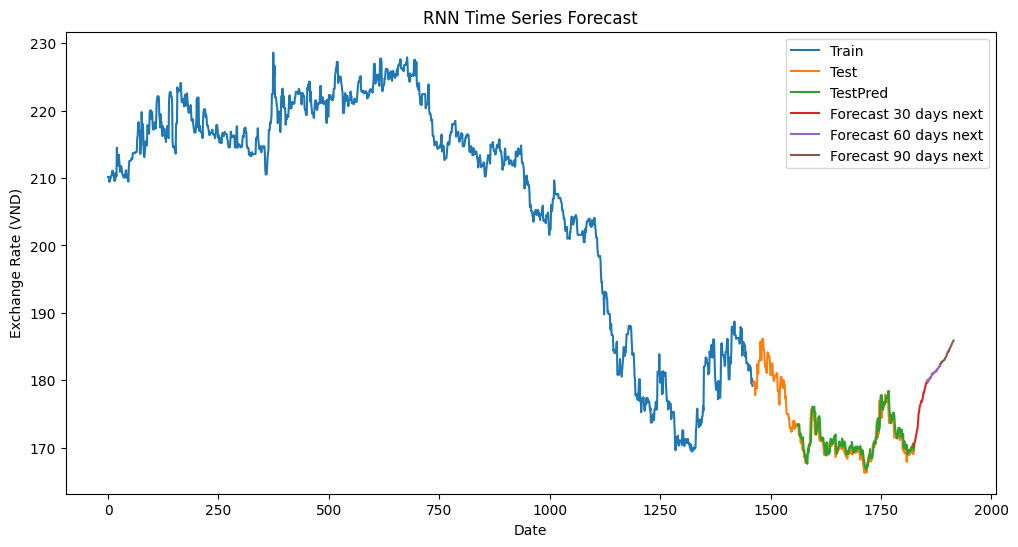

- Test: 
RMSE = 1.208080029462118
MAPE = 0.5155327739684005
MAE = 0.8828622968269119


In [18]:
implement_RNN(train_jpy_2_sc, test_jpy_2_sc)

- **Case 3. 9:1**

Epoch 1/100


C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1366 - val_loss: 0.0027
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0028 - val_loss: 0.0013
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011 - val_loss: 9.3000e-04
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.9395e-04 - val_loss: 6.8697e-04
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.9108e-04 - val_loss: 5.3538e-04
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.5119e-04 - val_loss: 6.1536e-04
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.0702e-04 - val_loss: 4.7585e-04
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.3966e-04 - val_loss: 3.7032e-04
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.3597e-04 - val_loss: 3.5104e-04
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.8778e-04 - val_loss: 4.1231e-04
Epoch 12

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.2207e-04 - val_loss: 2.9794e-04
Epoch 66/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.1693e-04 - val_loss: 3.9563e-04
Epoch 67/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.2272e-04 - val_loss: 2.8131e-04
Epoch 68/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.3775e-04 - val_loss: 3.7641e-04
Epoch 69/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.0692e-04 - val_loss: 4.3696e-04
Epoch 70/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.9529e-04 - val_loss: 3.0336e-04
Epoch 71/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.2495e-04 - val_loss: 2.7840e-04
Epoch 72/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.4906e-04 - val_loss: 2.5796e-04
Epoch 73/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.2045e-04 - val_loss: 2.6945e-04
Epoch 74/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.3636e-04 - val_loss: 2.5139e-04
Epoch 75/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.9710e-04 

4 day output [[0.08661297]]
5 day input [0.04139259 0.06160757 0.06898765 0.0612867  0.0612867  0.0612867
 0.07684903 0.07091288 0.06866677 0.10717151 0.12000642 0.12000642
 0.12000642 0.08471041 0.10075405 0.09337398 0.17182737 0.17054388
 0.17054388 0.17054388 0.16877908 0.13043478 0.14631798 0.15129151
 0.15963421 0.15963421 0.15963421 0.15754853 0.16348468 0.16300337
 0.18626665 0.17006257 0.17006257 0.17006257 0.18305792 0.18145355
 0.16781646 0.14310926 0.11856249 0.11856249 0.11856249 0.12754693
 0.1384566  0.12642387 0.12145034 0.13396438 0.13396438 0.13396438
 0.12112947 0.11070111 0.08406867 0.08535216 0.08390823 0.08390823
 0.08390823 0.08214343 0.09112787 0.09898925 0.09754532 0.09401572
 0.09401572 0.09401572 0.08615434 0.07781165 0.08118081 0.08968394
 0.08454998 0.08454998 0.08454998 0.05647361 0.0524627  0.07059201
 0.05888015 0.04684742 0.04684742 0.04684742 0.0506979  0.04251564
 0.02583026 0.03818386 0.0454035  0.0454035  0.0454035  0.04957484
 0.04219477 0.04524306 

14 day output [[0.16783546]]
15 day input [0.12000642 0.12000642 0.12000642 0.08471041 0.10075405 0.09337398
 0.17182737 0.17054388 0.17054388 0.17054388 0.16877908 0.13043478
 0.14631798 0.15129151 0.15963421 0.15963421 0.15963421 0.15754853
 0.16348468 0.16300337 0.18626665 0.17006257 0.17006257 0.17006257
 0.18305792 0.18145355 0.16781646 0.14310926 0.11856249 0.11856249
 0.11856249 0.12754693 0.1384566  0.12642387 0.12145034 0.13396438
 0.13396438 0.13396438 0.12112947 0.11070111 0.08406867 0.08535216
 0.08390823 0.08390823 0.08390823 0.08214343 0.09112787 0.09898925
 0.09754532 0.09401572 0.09401572 0.09401572 0.08615434 0.07781165
 0.08118081 0.08968394 0.08454998 0.08454998 0.08454998 0.05647361
 0.0524627  0.07059201 0.05888015 0.04684742 0.04684742 0.04684742
 0.0506979  0.04251564 0.02583026 0.03818386 0.0454035  0.0454035
 0.0454035  0.04957484 0.04219477 0.04524306 0.05053746 0.04989572
 0.04989572 0.04989572 0.05519012 0.05310444 0.04412001 0.06369325
 0.04700786 0.0587524

24 day output [[0.22906014]]
25 day input [0.16877908 0.13043478 0.14631798 0.15129151 0.15963421 0.15963421
 0.15963421 0.15754853 0.16348468 0.16300337 0.18626665 0.17006257
 0.17006257 0.17006257 0.18305792 0.18145355 0.16781646 0.14310926
 0.11856249 0.11856249 0.11856249 0.12754693 0.1384566  0.12642387
 0.12145034 0.13396438 0.13396438 0.13396438 0.12112947 0.11070111
 0.08406867 0.08535216 0.08390823 0.08390823 0.08390823 0.08214343
 0.09112787 0.09898925 0.09754532 0.09401572 0.09401572 0.09401572
 0.08615434 0.07781165 0.08118081 0.08968394 0.08454998 0.08454998
 0.08454998 0.05647361 0.0524627  0.07059201 0.05888015 0.04684742
 0.04684742 0.04684742 0.0506979  0.04251564 0.02583026 0.03818386
 0.0454035  0.0454035  0.0454035  0.04957484 0.04219477 0.04524306
 0.05053746 0.04989572 0.04989572 0.04989572 0.05519012 0.05310444
 0.04412001 0.06369325 0.04700786 0.0587524  0.07166496 0.07490791
 0.08092643 0.08661297 0.10001142 0.10288811 0.11612196 0.12331294
 0.12887585 0.133945

34 day output [[0.27253953]]
35 day input [0.18626665 0.17006257 0.17006257 0.17006257 0.18305792 0.18145355
 0.16781646 0.14310926 0.11856249 0.11856249 0.11856249 0.12754693
 0.1384566  0.12642387 0.12145034 0.13396438 0.13396438 0.13396438
 0.12112947 0.11070111 0.08406867 0.08535216 0.08390823 0.08390823
 0.08390823 0.08214343 0.09112787 0.09898925 0.09754532 0.09401572
 0.09401572 0.09401572 0.08615434 0.07781165 0.08118081 0.08968394
 0.08454998 0.08454998 0.08454998 0.05647361 0.0524627  0.07059201
 0.05888015 0.04684742 0.04684742 0.04684742 0.0506979  0.04251564
 0.02583026 0.03818386 0.0454035  0.0454035  0.0454035  0.04957484
 0.04219477 0.04524306 0.05053746 0.04989572 0.04989572 0.04989572
 0.05519012 0.05310444 0.04412001 0.06369325 0.04700786 0.0587524
 0.07166496 0.07490791 0.08092643 0.08661297 0.10001142 0.10288811
 0.11612196 0.12331294 0.12887585 0.13394584 0.14946263 0.15056062
 0.16130242 0.16783546 0.17303044 0.17765908 0.18739253 0.19494675
 0.19994958 0.2071008

44 day output [[0.30025786]]
45 day input [0.11856249 0.12754693 0.1384566  0.12642387 0.12145034 0.13396438
 0.13396438 0.13396438 0.12112947 0.11070111 0.08406867 0.08535216
 0.08390823 0.08390823 0.08390823 0.08214343 0.09112787 0.09898925
 0.09754532 0.09401572 0.09401572 0.09401572 0.08615434 0.07781165
 0.08118081 0.08968394 0.08454998 0.08454998 0.08454998 0.05647361
 0.0524627  0.07059201 0.05888015 0.04684742 0.04684742 0.04684742
 0.0506979  0.04251564 0.02583026 0.03818386 0.0454035  0.0454035
 0.0454035  0.04957484 0.04219477 0.04524306 0.05053746 0.04989572
 0.04989572 0.04989572 0.05519012 0.05310444 0.04412001 0.06369325
 0.04700786 0.0587524  0.07166496 0.07490791 0.08092643 0.08661297
 0.10001142 0.10288811 0.11612196 0.12331294 0.12887585 0.13394584
 0.14946263 0.15056062 0.16130242 0.16783546 0.17303044 0.17765908
 0.18739253 0.19494675 0.19994958 0.20710088 0.2110845  0.2150238
 0.21870355 0.22906014 0.23319057 0.23787238 0.24475676 0.24859376
 0.25312629 0.25883698

54 day output [[0.3228042]]
55 day input [0.08406867 0.08535216 0.08390823 0.08390823 0.08390823 0.08214343
 0.09112787 0.09898925 0.09754532 0.09401572 0.09401572 0.09401572
 0.08615434 0.07781165 0.08118081 0.08968394 0.08454998 0.08454998
 0.08454998 0.05647361 0.0524627  0.07059201 0.05888015 0.04684742
 0.04684742 0.04684742 0.0506979  0.04251564 0.02583026 0.03818386
 0.0454035  0.0454035  0.0454035  0.04957484 0.04219477 0.04524306
 0.05053746 0.04989572 0.04989572 0.04989572 0.05519012 0.05310444
 0.04412001 0.06369325 0.04700786 0.0587524  0.07166496 0.07490791
 0.08092643 0.08661297 0.10001142 0.10288811 0.11612196 0.12331294
 0.12887585 0.13394584 0.14946263 0.15056062 0.16130242 0.16783546
 0.17303044 0.17765908 0.18739253 0.19494675 0.19994958 0.20710088
 0.2110845  0.2150238  0.21870355 0.22906014 0.23319057 0.23787238
 0.24475676 0.24859376 0.25312629 0.25883698 0.26358664 0.26667994
 0.27208415 0.27253953 0.27639043 0.28085336 0.28252795 0.28463674
 0.2874594  0.2893466

64 day output [[0.3468847]]
65 day input [0.09401572 0.09401572 0.08615434 0.07781165 0.08118081 0.08968394
 0.08454998 0.08454998 0.08454998 0.05647361 0.0524627  0.07059201
 0.05888015 0.04684742 0.04684742 0.04684742 0.0506979  0.04251564
 0.02583026 0.03818386 0.0454035  0.0454035  0.0454035  0.04957484
 0.04219477 0.04524306 0.05053746 0.04989572 0.04989572 0.04989572
 0.05519012 0.05310444 0.04412001 0.06369325 0.04700786 0.0587524
 0.07166496 0.07490791 0.08092643 0.08661297 0.10001142 0.10288811
 0.11612196 0.12331294 0.12887585 0.13394584 0.14946263 0.15056062
 0.16130242 0.16783546 0.17303044 0.17765908 0.18739253 0.19494675
 0.19994958 0.20710088 0.2110845  0.2150238  0.21870355 0.22906014
 0.23319057 0.23787238 0.24475676 0.24859376 0.25312629 0.25883698
 0.26358664 0.26667994 0.27208415 0.27253953 0.27639043 0.28085336
 0.28252795 0.28463674 0.2874594  0.28934661 0.28946722 0.29506245
 0.2976172  0.30025786 0.30231446 0.30627254 0.3076658  0.31087515
 0.3133356  0.31526294

74 day output [[0.37068957]]
75 day input [0.0524627  0.07059201 0.05888015 0.04684742 0.04684742 0.04684742
 0.0506979  0.04251564 0.02583026 0.03818386 0.0454035  0.0454035
 0.0454035  0.04957484 0.04219477 0.04524306 0.05053746 0.04989572
 0.04989572 0.04989572 0.05519012 0.05310444 0.04412001 0.06369325
 0.04700786 0.0587524  0.07166496 0.07490791 0.08092643 0.08661297
 0.10001142 0.10288811 0.11612196 0.12331294 0.12887585 0.13394584
 0.14946263 0.15056062 0.16130242 0.16783546 0.17303044 0.17765908
 0.18739253 0.19494675 0.19994958 0.20710088 0.2110845  0.2150238
 0.21870355 0.22906014 0.23319057 0.23787238 0.24475676 0.24859376
 0.25312629 0.25883698 0.26358664 0.26667994 0.27208415 0.27253953
 0.27639043 0.28085336 0.28252795 0.28463674 0.2874594  0.28934661
 0.28946722 0.29506245 0.2976172  0.30025786 0.30231446 0.30627254
 0.3076658  0.31087515 0.3133356  0.31526294 0.31641108 0.31974152
 0.32070217 0.32280421 0.32738978 0.32980514 0.33116344 0.33404768
 0.33634835 0.33746925

84 day output [[0.39790514]]
85 day input [0.0454035  0.0454035  0.0454035  0.04957484 0.04219477 0.04524306
 0.05053746 0.04989572 0.04989572 0.04989572 0.05519012 0.05310444
 0.04412001 0.06369325 0.04700786 0.0587524  0.07166496 0.07490791
 0.08092643 0.08661297 0.10001142 0.10288811 0.11612196 0.12331294
 0.12887585 0.13394584 0.14946263 0.15056062 0.16130242 0.16783546
 0.17303044 0.17765908 0.18739253 0.19494675 0.19994958 0.20710088
 0.2110845  0.2150238  0.21870355 0.22906014 0.23319057 0.23787238
 0.24475676 0.24859376 0.25312629 0.25883698 0.26358664 0.26667994
 0.27208415 0.27253953 0.27639043 0.28085336 0.28252795 0.28463674
 0.2874594  0.28934661 0.28946722 0.29506245 0.2976172  0.30025786
 0.30231446 0.30627254 0.3076658  0.31087515 0.3133356  0.31526294
 0.31641108 0.31974152 0.32070217 0.32280421 0.32738978 0.32980514
 0.33116344 0.33404768 0.33634835 0.33746925 0.34029809 0.34317765
 0.34391698 0.3468847  0.3489328  0.35132211 0.35323584 0.35749003
 0.35825101 0.360880

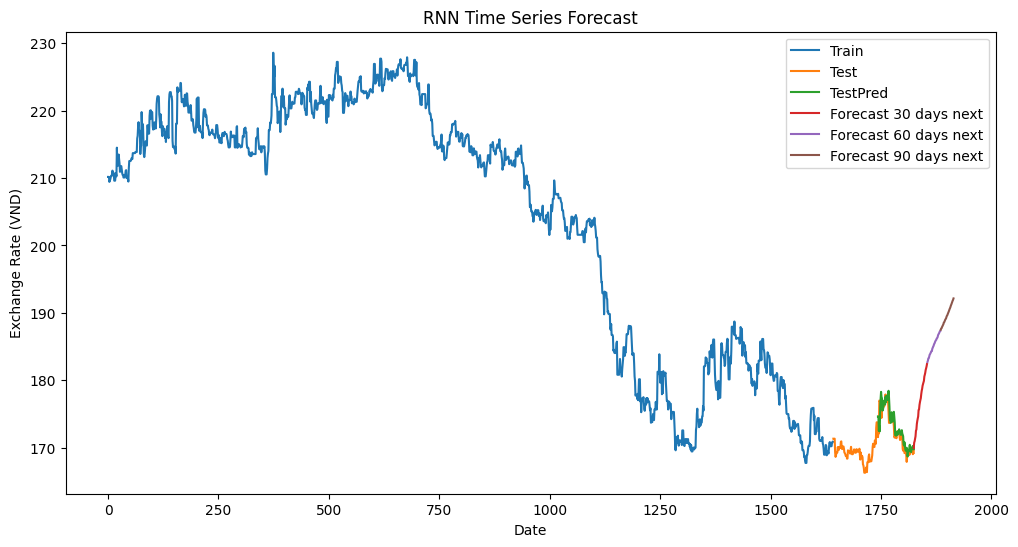

- Test: 
RMSE = 1.371937145424356
MAPE = 0.5497316334184755
MAE = 0.9507677255025733


In [19]:
implement_RNN(train_jpy_3_sc, test_jpy_3_sc)